# Imports
Make sure to run `pip install -r requirements.txt` before running this notebook.

In [1]:
import sys
import os
import jax
import jax.numpy as jnp
import neural_tangents as nt
from neural_tangents import stax
import time
import numpy as np

import matplotlib.pyplot as plt
import pandas as pd
import optax
from IPython.display import display 

from typing import Any, Callable, Sequence, Optional, Union

key = jax.random.PRNGKey(0)

In [2]:
# Configure Matplotlib for better inline plots
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.style.use('seaborn-v0_8-whitegrid')

In [33]:
# importing the analyzer class
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from util.ntk_analyzer import NTKAnalyzer
from util.helper import create_mlp_stax, create_mlp_stax_2

In [34]:
import dill
import os

output_directory = "data"

# Initialize data and the network

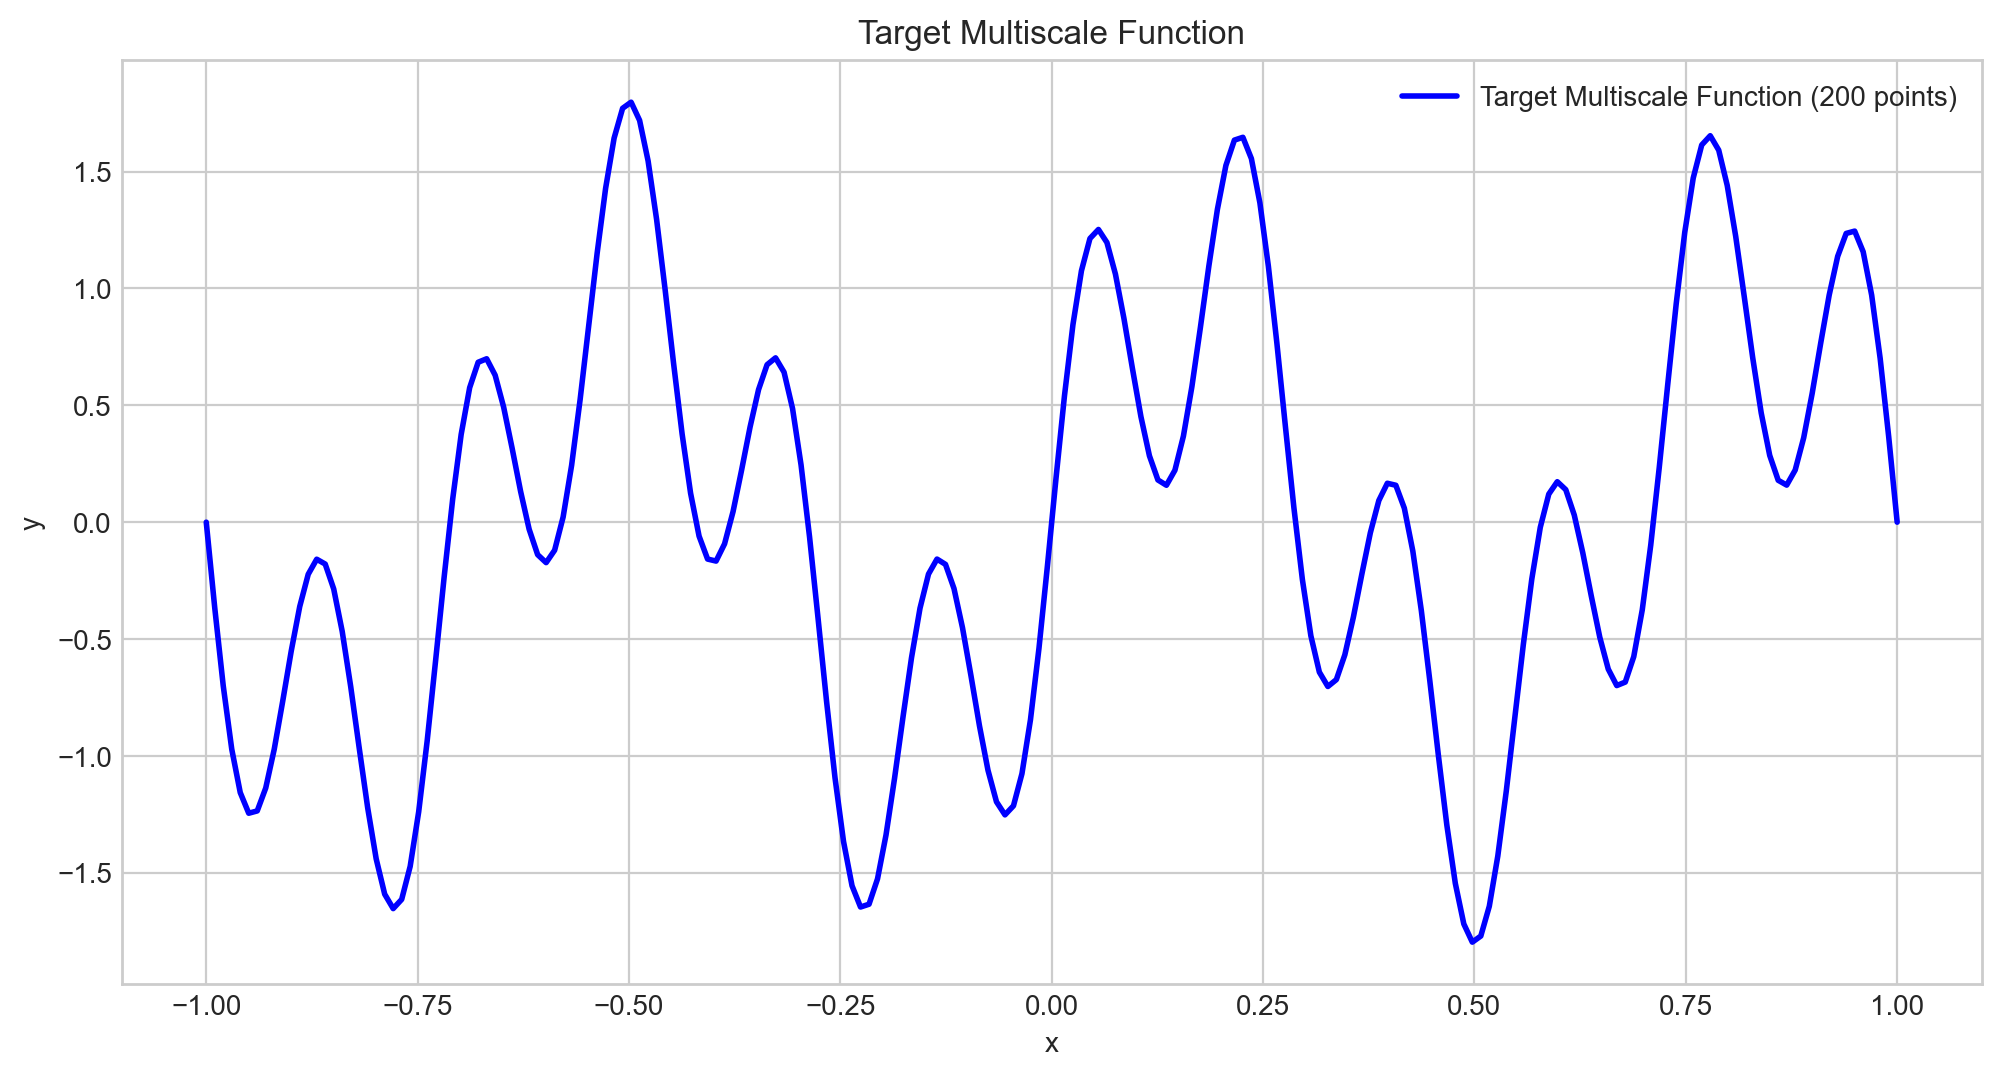

X_train shape: (200, 1), Y_train shape: (200, 1)


In [35]:
key_data_gen, key_sample = jax.random.split(key, 2)
key = key_data_gen 

N_TRAIN_SAMPLES = 200 # careful, too much could halt your computer

X_domain_min = -1.0
X_domain_max = 1.0

X_train = jnp.linspace(X_domain_min, X_domain_max, N_TRAIN_SAMPLES)[:, None]
Y_train = jnp.sin(3 * jnp.pi * X_train) + 0.8 * jnp.sin(11 * jnp.pi * X_train)

X_test = jnp.linspace(X_domain_min - 0.1, X_domain_max + 0.1, 400)[:, None] 
Y_test_true = jnp.sin(3 * jnp.pi * X_test) + 0.8 * jnp.sin(11 * jnp.pi * X_test)

INPUT_DIM = X_train.shape[1]
OUTPUT_DIM = Y_train.shape[1]

plt.figure(figsize=(12, 6))
plt.plot(X_train, Y_train, label=f'Target Multiscale Function ({N_TRAIN_SAMPLES} points)', color='blue', linewidth=2)
plt.xlabel('x')
plt.ylabel('y')
plt.legend(loc='upper right')
plt.title('Target Multiscale Function')
plt.grid(True)
plt.show()

print(f"X_train shape: {X_train.shape}, Y_train shape: {Y_train.shape}")


Network Architecture: InputDim=1, HiddenLayers=2, HiddenWidth=1024, OutputDim=1
Layer widths for NTKAnalyzer: [1, 1024, 1024, 1]
Activation function: (<function _elementwise.<locals>.<lambda> at 0x339874860>, <function supports_masking.<locals>.supports_masking.<locals>.layer_with_masking.<locals>.apply_fn_with_masking at 0x31d4565c0>, <function _preprocess_kernel_fn.<locals>.kernel_fn_any at 0x31d378220>)


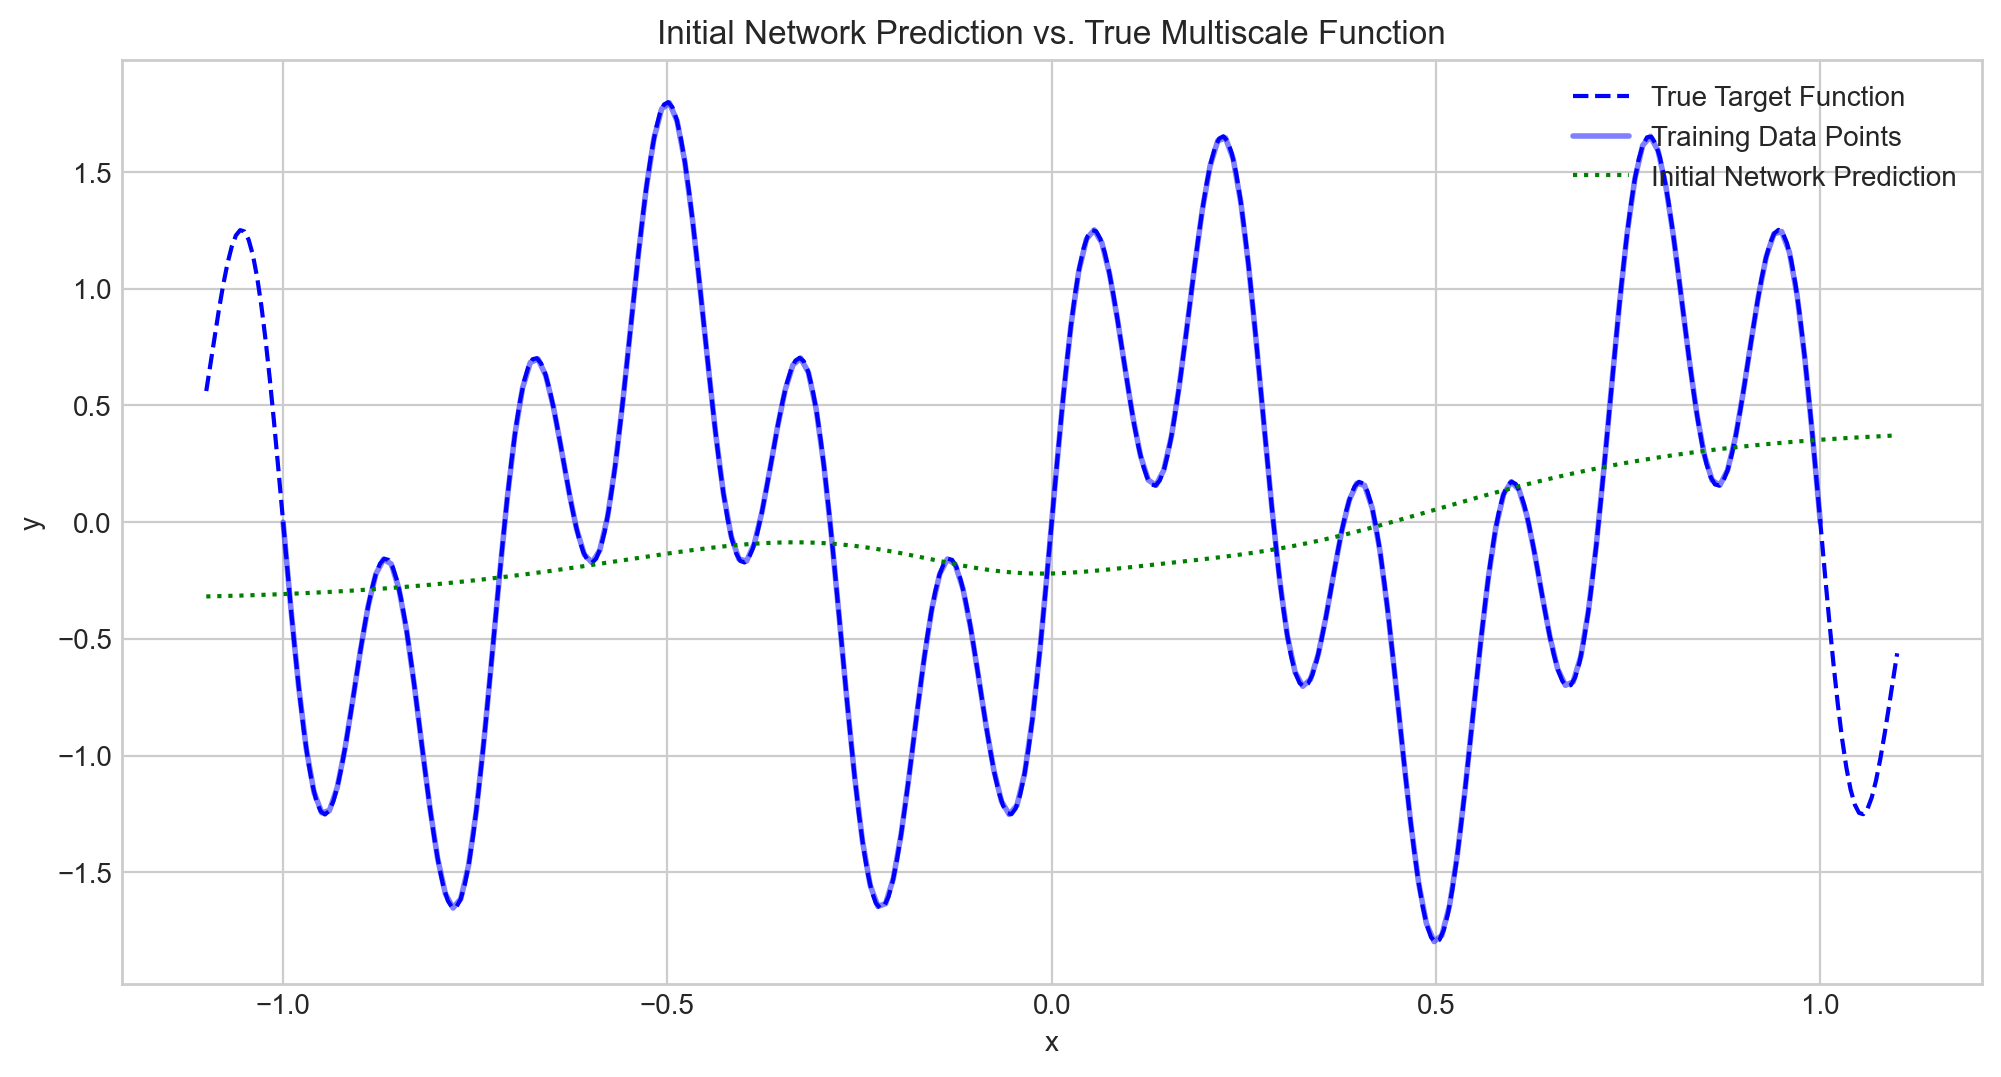

In [36]:
key, init_key = jax.random.split(key)

HIDDEN_LAYERS = 2      
HIDDEN_WIDTH = 1024     
ACTIVATION_FN_STAX = stax.Erf() 

# for init of weights
W_STD = 1.5            
B_STD = 0.05

init_fn, net_apply_fn, net_stax_kernel_fn = create_mlp_stax(
    depth=HIDDEN_LAYERS, 
    hidden_width=HIDDEN_WIDTH,
    output_dim=OUTPUT_DIM,
    activation_stax_fn=ACTIVATION_FN_STAX,
    W_std=W_STD,
    b_std=B_STD
)

layer_widths_spec = [INPUT_DIM] + [HIDDEN_WIDTH] * HIDDEN_LAYERS + [OUTPUT_DIM]

_, params_initial = init_fn(init_key, (-1, INPUT_DIM)) 

print(f"\nNetwork Architecture: InputDim={INPUT_DIM}, HiddenLayers={HIDDEN_LAYERS}, HiddenWidth={HIDDEN_WIDTH}, OutputDim={OUTPUT_DIM}")
print(f"Layer widths for NTKAnalyzer: {layer_widths_spec}")
print(f"Activation function: {ACTIVATION_FN_STAX}")

Y_pred_initial = net_apply_fn(params_initial, X_test)

plt.figure(figsize=(12, 6))
plt.plot(X_test, Y_test_true, label='True Target Function', color='blue', linestyle='--')
plt.plot(X_train, Y_train, label='Training Data Points', color='blue', alpha=0.5, linewidth=2) 
plt.plot(X_test, Y_pred_initial, label='Initial Network Prediction', color='green', linestyle=':')
plt.title('Initial Network Prediction vs. True Multiscale Function')
plt.xlabel('x')
plt.ylabel('y')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

In [25]:
import pandas as pd

ACTIVATION_FUNCTIONS = {
    "ReLU": stax.Relu(),
    "Sigmoid_like": stax.Sigmoid_like(),
    "Gelu": stax.Gelu()
}

CURRENT_ACTIVATION = "Gelu"

network_configurations = [
    # Group 1: Fixed Width, Varying Depth
    # W = 16
    {"name": "D1_W16",   "HIDDEN_LAYERS": 1,   "HIDDEN_WIDTH": 16,  "ACTIVATION_FN_STAX": ACTIVATION_FUNCTIONS[CURRENT_ACTIVATION], "ACTIVATION_NAME": CURRENT_ACTIVATION, "W_STD": jnp.sqrt(2.0), "B_STD": 0.0}, # beta = 1/16 = 0.0625
    {"name": "D2_W16",   "HIDDEN_LAYERS": 2,   "HIDDEN_WIDTH": 16,  "ACTIVATION_FN_STAX": ACTIVATION_FUNCTIONS[CURRENT_ACTIVATION], "ACTIVATION_NAME": CURRENT_ACTIVATION, "W_STD": jnp.sqrt(2.0), "B_STD": 0.0}, # beta = 2/16 = 0.125
    {"name": "D4_W16",   "HIDDEN_LAYERS": 4,   "HIDDEN_WIDTH": 16,  "ACTIVATION_FN_STAX": ACTIVATION_FUNCTIONS[CURRENT_ACTIVATION], "ACTIVATION_NAME": CURRENT_ACTIVATION, "W_STD": jnp.sqrt(2.0), "B_STD": 0.0}, # beta = 4/16 = 0.25
    {"name": "D8_W16",   "HIDDEN_LAYERS": 8,   "HIDDEN_WIDTH": 16,  "ACTIVATION_FN_STAX": ACTIVATION_FUNCTIONS[CURRENT_ACTIVATION], "ACTIVATION_NAME": CURRENT_ACTIVATION, "W_STD": jnp.sqrt(2.0), "B_STD": 0.0}, # beta = 8/16 = 0.5
    {"name": "D16_W16",  "HIDDEN_LAYERS": 16,  "HIDDEN_WIDTH": 16,  "ACTIVATION_FN_STAX": ACTIVATION_FUNCTIONS[CURRENT_ACTIVATION], "ACTIVATION_NAME": CURRENT_ACTIVATION, "W_STD": jnp.sqrt(2.0), "B_STD": 0.0}, # beta = 16/16 = 1.0
    {"name": "D32_W16",  "HIDDEN_LAYERS": 32,  "HIDDEN_WIDTH": 16,  "ACTIVATION_FN_STAX": ACTIVATION_FUNCTIONS[CURRENT_ACTIVATION], "ACTIVATION_NAME": CURRENT_ACTIVATION, "W_STD": jnp.sqrt(2.0), "B_STD": 0.0}, # beta = 32/16 = 2.0
    {"name": "D48_W16",  "HIDDEN_LAYERS": 48,  "HIDDEN_WIDTH": 16,  "ACTIVATION_FN_STAX": ACTIVATION_FUNCTIONS[CURRENT_ACTIVATION], "ACTIVATION_NAME": CURRENT_ACTIVATION, "W_STD": jnp.sqrt(2.0), "B_STD": 0.0}, # beta = 48/16 = 3.0
    {"name": "D64_W16",  "HIDDEN_LAYERS": 64,  "HIDDEN_WIDTH": 16,  "ACTIVATION_FN_STAX": ACTIVATION_FUNCTIONS[CURRENT_ACTIVATION], "ACTIVATION_NAME": CURRENT_ACTIVATION, "W_STD": jnp.sqrt(2.0), "B_STD": 0.0}, # beta = 64/16 = 4.0

    # W = 32
    {"name": "D1_W32",   "HIDDEN_LAYERS": 1,   "HIDDEN_WIDTH": 32,  "ACTIVATION_FN_STAX": ACTIVATION_FUNCTIONS[CURRENT_ACTIVATION], "ACTIVATION_NAME": CURRENT_ACTIVATION, "W_STD": jnp.sqrt(2.0), "B_STD": 0.0}, # beta = 1/32 = 0.03125
    {"name": "D2_W32",   "HIDDEN_LAYERS": 2,   "HIDDEN_WIDTH": 32,  "ACTIVATION_FN_STAX": ACTIVATION_FUNCTIONS[CURRENT_ACTIVATION], "ACTIVATION_NAME": CURRENT_ACTIVATION, "W_STD": jnp.sqrt(2.0), "B_STD": 0.0}, # beta = 2/32 = 0.0625
    {"name": "D3_W32",   "HIDDEN_LAYERS": 3,   "HIDDEN_WIDTH": 32,  "ACTIVATION_FN_STAX": ACTIVATION_FUNCTIONS[CURRENT_ACTIVATION], "ACTIVATION_NAME": CURRENT_ACTIVATION, "W_STD": jnp.sqrt(2.0), "B_STD": 0.0}, # beta = 3/32 = 0.09375
    {"name": "D4_W32",   "HIDDEN_LAYERS": 4,   "HIDDEN_WIDTH": 32,  "ACTIVATION_FN_STAX": ACTIVATION_FUNCTIONS[CURRENT_ACTIVATION], "ACTIVATION_NAME": CURRENT_ACTIVATION, "W_STD": jnp.sqrt(2.0), "B_STD": 0.0}, # beta = 4/32 = 0.125
    {"name": "D6_W32",   "HIDDEN_LAYERS": 6,   "HIDDEN_WIDTH": 32,  "ACTIVATION_FN_STAX": ACTIVATION_FUNCTIONS[CURRENT_ACTIVATION], "ACTIVATION_NAME": CURRENT_ACTIVATION, "W_STD": jnp.sqrt(2.0), "B_STD": 0.0}, # beta = 6/32 = 0.1875
    {"name": "D8_W32",   "HIDDEN_LAYERS": 8,   "HIDDEN_WIDTH": 32,  "ACTIVATION_FN_STAX": ACTIVATION_FUNCTIONS[CURRENT_ACTIVATION], "ACTIVATION_NAME": CURRENT_ACTIVATION, "W_STD": jnp.sqrt(2.0), "B_STD": 0.0}, # beta = 8/32 = 0.25
    {"name": "D10_W32",  "HIDDEN_LAYERS": 10,  "HIDDEN_WIDTH": 32,  "ACTIVATION_FN_STAX": ACTIVATION_FUNCTIONS[CURRENT_ACTIVATION], "ACTIVATION_NAME": CURRENT_ACTIVATION, "W_STD": jnp.sqrt(2.0), "B_STD": 0.0}, # beta = 10/32 = 0.3125
    {"name": "D16_W32",  "HIDDEN_LAYERS": 16,  "HIDDEN_WIDTH": 32,  "ACTIVATION_FN_STAX": ACTIVATION_FUNCTIONS[CURRENT_ACTIVATION], "ACTIVATION_NAME": CURRENT_ACTIVATION, "W_STD": jnp.sqrt(2.0), "B_STD": 0.0}, # beta = 16/32 = 0.5
    {"name": "D24_W32",  "HIDDEN_LAYERS": 24,  "HIDDEN_WIDTH": 32,  "ACTIVATION_FN_STAX": ACTIVATION_FUNCTIONS[CURRENT_ACTIVATION], "ACTIVATION_NAME": CURRENT_ACTIVATION, "W_STD": jnp.sqrt(2.0), "B_STD": 0.0}, # beta = 24/32 = 0.75
    {"name": "D32_W32",  "HIDDEN_LAYERS": 32,  "HIDDEN_WIDTH": 32,  "ACTIVATION_FN_STAX": ACTIVATION_FUNCTIONS[CURRENT_ACTIVATION], "ACTIVATION_NAME": CURRENT_ACTIVATION, "W_STD": jnp.sqrt(2.0), "B_STD": 0.0}, # beta = 32/32 = 1.0
    {"name": "D40_W32",  "HIDDEN_LAYERS": 40,  "HIDDEN_WIDTH": 32,  "ACTIVATION_FN_STAX": ACTIVATION_FUNCTIONS[CURRENT_ACTIVATION], "ACTIVATION_NAME": CURRENT_ACTIVATION, "W_STD": jnp.sqrt(2.0), "B_STD": 0.0}, # beta = 40/32 = 1.25
    {"name": "D48_W32",  "HIDDEN_LAYERS": 48,  "HIDDEN_WIDTH": 32,  "ACTIVATION_FN_STAX": ACTIVATION_FUNCTIONS[CURRENT_ACTIVATION], "ACTIVATION_NAME": CURRENT_ACTIVATION, "W_STD": jnp.sqrt(2.0), "B_STD": 0.0}, # beta = 48/32 = 1.5
    {"name": "D64_W32",  "HIDDEN_LAYERS": 64,  "HIDDEN_WIDTH": 32,  "ACTIVATION_FN_STAX": ACTIVATION_FUNCTIONS[CURRENT_ACTIVATION], "ACTIVATION_NAME": CURRENT_ACTIVATION, "W_STD": jnp.sqrt(2.0), "B_STD": 0.0}, # beta = 64/32 = 2.0

    # W = 64
    {"name": "D1_W64",   "HIDDEN_LAYERS": 1,   "HIDDEN_WIDTH": 64,  "ACTIVATION_FN_STAX": ACTIVATION_FUNCTIONS[CURRENT_ACTIVATION], "ACTIVATION_NAME": CURRENT_ACTIVATION, "W_STD": jnp.sqrt(2.0), "B_STD": 0.0}, # beta = 1/64 = 0.015625
    {"name": "D2_W64",   "HIDDEN_LAYERS": 2,   "HIDDEN_WIDTH": 64,  "ACTIVATION_FN_STAX": ACTIVATION_FUNCTIONS[CURRENT_ACTIVATION], "ACTIVATION_NAME": CURRENT_ACTIVATION, "W_STD": jnp.sqrt(2.0), "B_STD": 0.0}, # beta = 2/64 = 0.03125
    {"name": "D3_W64",   "HIDDEN_LAYERS": 3,   "HIDDEN_WIDTH": 64,  "ACTIVATION_FN_STAX": ACTIVATION_FUNCTIONS[CURRENT_ACTIVATION], "ACTIVATION_NAME": CURRENT_ACTIVATION, "W_STD": jnp.sqrt(2.0), "B_STD": 0.0}, # beta = 3/64 = 0.046875
    {"name": "D4_W64",   "HIDDEN_LAYERS": 4,   "HIDDEN_WIDTH": 64,  "ACTIVATION_FN_STAX": ACTIVATION_FUNCTIONS[CURRENT_ACTIVATION], "ACTIVATION_NAME": CURRENT_ACTIVATION, "W_STD": jnp.sqrt(2.0), "B_STD": 0.0}, # beta = 4/64 = 0.0625
    {"name": "D6_W64",   "HIDDEN_LAYERS": 6,   "HIDDEN_WIDTH": 64,  "ACTIVATION_FN_STAX": ACTIVATION_FUNCTIONS[CURRENT_ACTIVATION], "ACTIVATION_NAME": CURRENT_ACTIVATION, "W_STD": jnp.sqrt(2.0), "B_STD": 0.0}, # beta = 6/64 = 0.09375
    {"name": "D8_W64",   "HIDDEN_LAYERS": 8,   "HIDDEN_WIDTH": 64,  "ACTIVATION_FN_STAX": ACTIVATION_FUNCTIONS[CURRENT_ACTIVATION], "ACTIVATION_NAME": CURRENT_ACTIVATION, "W_STD": jnp.sqrt(2.0), "B_STD": 0.0}, # beta = 8/64 = 0.125
    {"name": "D12_W64",  "HIDDEN_LAYERS": 12,  "HIDDEN_WIDTH": 64,  "ACTIVATION_FN_STAX": ACTIVATION_FUNCTIONS[CURRENT_ACTIVATION], "ACTIVATION_NAME": CURRENT_ACTIVATION, "W_STD": jnp.sqrt(2.0), "B_STD": 0.0}, # beta = 12/64 = 0.1875
    {"name": "D16_W64",  "HIDDEN_LAYERS": 16,  "HIDDEN_WIDTH": 64,  "ACTIVATION_FN_STAX": ACTIVATION_FUNCTIONS[CURRENT_ACTIVATION], "ACTIVATION_NAME": CURRENT_ACTIVATION, "W_STD": jnp.sqrt(2.0), "B_STD": 0.0}, # beta = 16/64 = 0.25
    {"name": "D24_W64",  "HIDDEN_LAYERS": 24,  "HIDDEN_WIDTH": 64,  "ACTIVATION_FN_STAX": ACTIVATION_FUNCTIONS[CURRENT_ACTIVATION], "ACTIVATION_NAME": CURRENT_ACTIVATION, "W_STD": jnp.sqrt(2.0), "B_STD": 0.0}, # beta = 24/64 = 0.375
    {"name": "D32_W64",  "HIDDEN_LAYERS": 32,  "HIDDEN_WIDTH": 64,  "ACTIVATION_FN_STAX": ACTIVATION_FUNCTIONS[CURRENT_ACTIVATION], "ACTIVATION_NAME": CURRENT_ACTIVATION, "W_STD": jnp.sqrt(2.0), "B_STD": 0.0}, # beta = 32/64 = 0.5
    {"name": "D48_W64",  "HIDDEN_LAYERS": 48,  "HIDDEN_WIDTH": 64,  "ACTIVATION_FN_STAX": ACTIVATION_FUNCTIONS[CURRENT_ACTIVATION], "ACTIVATION_NAME": CURRENT_ACTIVATION, "W_STD": jnp.sqrt(2.0), "B_STD": 0.0}, # beta = 48/64 = 0.75
    {"name": "D64_W64",  "HIDDEN_LAYERS": 64,  "HIDDEN_WIDTH": 64,  "ACTIVATION_FN_STAX": ACTIVATION_FUNCTIONS[CURRENT_ACTIVATION], "ACTIVATION_NAME": CURRENT_ACTIVATION, "W_STD": jnp.sqrt(2.0), "B_STD": 0.0}, # beta = 64/64 = 1.0
    {"name": "D80_W64",  "HIDDEN_LAYERS": 80,  "HIDDEN_WIDTH": 64,  "ACTIVATION_FN_STAX": ACTIVATION_FUNCTIONS[CURRENT_ACTIVATION], "ACTIVATION_NAME": CURRENT_ACTIVATION, "W_STD": jnp.sqrt(2.0), "B_STD": 0.0}, # beta = 80/64 = 1.25
    {"name": "D96_W64",  "HIDDEN_LAYERS": 96,  "HIDDEN_WIDTH": 64,  "ACTIVATION_FN_STAX": ACTIVATION_FUNCTIONS[CURRENT_ACTIVATION], "ACTIVATION_NAME": CURRENT_ACTIVATION, "W_STD": jnp.sqrt(2.0), "B_STD": 0.0}, # beta = 96/64 = 1.5

    # W = 128
    {"name": "D1_W128",  "HIDDEN_LAYERS": 1,   "HIDDEN_WIDTH": 128, "ACTIVATION_FN_STAX": ACTIVATION_FUNCTIONS[CURRENT_ACTIVATION], "ACTIVATION_NAME": CURRENT_ACTIVATION, "W_STD": jnp.sqrt(2.0), "B_STD": 0.0}, # beta = 1/128 = 0.0078125
    {"name": "D2_W128",  "HIDDEN_LAYERS": 2,   "HIDDEN_WIDTH": 128, "ACTIVATION_FN_STAX": ACTIVATION_FUNCTIONS[CURRENT_ACTIVATION], "ACTIVATION_NAME": CURRENT_ACTIVATION, "W_STD": jnp.sqrt(2.0), "B_STD": 0.0}, # beta = 2/128 = 0.015625
    {"name": "D4_W128",  "HIDDEN_LAYERS": 4,   "HIDDEN_WIDTH": 128, "ACTIVATION_FN_STAX": ACTIVATION_FUNCTIONS[CURRENT_ACTIVATION], "ACTIVATION_NAME": CURRENT_ACTIVATION, "W_STD": jnp.sqrt(2.0), "B_STD": 0.0}, # beta = 4/128 = 0.03125
    {"name": "D6_W128",  "HIDDEN_LAYERS": 6,   "HIDDEN_WIDTH": 128, "ACTIVATION_FN_STAX": ACTIVATION_FUNCTIONS[CURRENT_ACTIVATION], "ACTIVATION_NAME": CURRENT_ACTIVATION, "W_STD": jnp.sqrt(2.0), "B_STD": 0.0}, # beta = 6/128 = 0.046875
    {"name": "D8_W128",  "HIDDEN_LAYERS": 8,   "HIDDEN_WIDTH": 128, "ACTIVATION_FN_STAX": ACTIVATION_FUNCTIONS[CURRENT_ACTIVATION], "ACTIVATION_NAME": CURRENT_ACTIVATION, "W_STD": jnp.sqrt(2.0), "B_STD": 0.0}, # beta = 8/128 = 0.0625
    {"name": "D12_W128", "HIDDEN_LAYERS": 12,  "HIDDEN_WIDTH": 128, "ACTIVATION_FN_STAX": ACTIVATION_FUNCTIONS[CURRENT_ACTIVATION], "ACTIVATION_NAME": CURRENT_ACTIVATION, "W_STD": jnp.sqrt(2.0), "B_STD": 0.0}, # beta = 12/128 = 0.09375
    {"name": "D16_W128", "HIDDEN_LAYERS": 16,  "HIDDEN_WIDTH": 128, "ACTIVATION_FN_STAX": ACTIVATION_FUNCTIONS[CURRENT_ACTIVATION], "ACTIVATION_NAME": CURRENT_ACTIVATION, "W_STD": jnp.sqrt(2.0), "B_STD": 0.0}, # beta = 16/128 = 0.125
    {"name": "D32_W128", "HIDDEN_LAYERS": 32,  "HIDDEN_WIDTH": 128, "ACTIVATION_FN_STAX": ACTIVATION_FUNCTIONS[CURRENT_ACTIVATION], "ACTIVATION_NAME": CURRENT_ACTIVATION, "W_STD": jnp.sqrt(2.0), "B_STD": 0.0}, # beta = 32/128 = 0.25
    {"name": "D64_W128", "HIDDEN_LAYERS": 64,  "HIDDEN_WIDTH": 128, "ACTIVATION_FN_STAX": ACTIVATION_FUNCTIONS[CURRENT_ACTIVATION], "ACTIVATION_NAME": CURRENT_ACTIVATION, "W_STD": jnp.sqrt(2.0), "B_STD": 0.0}, # beta = 64/128 = 0.5
    {"name": "D96_W128", "HIDDEN_LAYERS": 96,  "HIDDEN_WIDTH": 128, "ACTIVATION_FN_STAX": ACTIVATION_FUNCTIONS[CURRENT_ACTIVATION], "ACTIVATION_NAME": CURRENT_ACTIVATION, "W_STD": jnp.sqrt(2.0), "B_STD": 0.0}, # beta = 96/128 = 0.75
    {"name": "D128_W128","HIDDEN_LAYERS": 128, "HIDDEN_WIDTH": 128, "ACTIVATION_FN_STAX": ACTIVATION_FUNCTIONS[CURRENT_ACTIVATION], "ACTIVATION_NAME": CURRENT_ACTIVATION, "W_STD": jnp.sqrt(2.0), "B_STD": 0.0}, # beta = 128/128 = 1.0

    # W = 256
    {"name": "D1_W256",  "HIDDEN_LAYERS": 1,   "HIDDEN_WIDTH": 256, "ACTIVATION_FN_STAX": ACTIVATION_FUNCTIONS[CURRENT_ACTIVATION], "ACTIVATION_NAME": CURRENT_ACTIVATION, "W_STD": jnp.sqrt(2.0), "B_STD": 0.0}, # beta = 1/256 = 0.00390625
    {"name": "D2_W256",  "HIDDEN_LAYERS": 2,   "HIDDEN_WIDTH": 256, "ACTIVATION_FN_STAX": ACTIVATION_FUNCTIONS[CURRENT_ACTIVATION], "ACTIVATION_NAME": CURRENT_ACTIVATION, "W_STD": jnp.sqrt(2.0), "B_STD": 0.0}, # beta = 2/256 = 0.0078125
    {"name": "D4_W256",  "HIDDEN_LAYERS": 4,   "HIDDEN_WIDTH": 256, "ACTIVATION_FN_STAX": ACTIVATION_FUNCTIONS[CURRENT_ACTIVATION], "ACTIVATION_NAME": CURRENT_ACTIVATION, "W_STD": jnp.sqrt(2.0), "B_STD": 0.0}, # beta = 4/256 = 0.015625
    {"name": "D8_W256",  "HIDDEN_LAYERS": 8,   "HIDDEN_WIDTH": 256, "ACTIVATION_FN_STAX": ACTIVATION_FUNCTIONS[CURRENT_ACTIVATION], "ACTIVATION_NAME": CURRENT_ACTIVATION, "W_STD": jnp.sqrt(2.0), "B_STD": 0.0}, # beta = 8/256 = 0.03125
    {"name": "D16_W256", "HIDDEN_LAYERS": 16,  "HIDDEN_WIDTH": 256, "ACTIVATION_FN_STAX": ACTIVATION_FUNCTIONS[CURRENT_ACTIVATION], "ACTIVATION_NAME": CURRENT_ACTIVATION, "W_STD": jnp.sqrt(2.0), "B_STD": 0.0}, # beta = 16/256 = 0.0625
    {"name": "D32_W256", "HIDDEN_LAYERS": 32,  "HIDDEN_WIDTH": 256, "ACTIVATION_FN_STAX": ACTIVATION_FUNCTIONS[CURRENT_ACTIVATION], "ACTIVATION_NAME": CURRENT_ACTIVATION, "W_STD": jnp.sqrt(2.0), "B_STD": 0.0}, # beta = 32/256 = 0.125
    {"name": "D64_W256", "HIDDEN_LAYERS": 64,  "HIDDEN_WIDTH": 256, "ACTIVATION_FN_STAX": ACTIVATION_FUNCTIONS[CURRENT_ACTIVATION], "ACTIVATION_NAME": CURRENT_ACTIVATION, "W_STD": jnp.sqrt(2.0), "B_STD": 0.0}, # beta = 64/256 = 0.25
    {"name": "D96_W256", "HIDDEN_LAYERS": 96,  "HIDDEN_WIDTH": 256, "ACTIVATION_FN_STAX": ACTIVATION_FUNCTIONS[CURRENT_ACTIVATION], "ACTIVATION_NAME": CURRENT_ACTIVATION, "W_STD": jnp.sqrt(2.0), "B_STD": 0.0}, # beta = 96/256 = 0.375
    {"name": "D192_W256","HIDDEN_LAYERS": 192, "HIDDEN_WIDTH": 256, "ACTIVATION_FN_STAX": ACTIVATION_FUNCTIONS[CURRENT_ACTIVATION], "ACTIVATION_NAME": CURRENT_ACTIVATION, "W_STD": jnp.sqrt(2.0), "B_STD": 0.0}, # beta = 192/256 = 0.75

    # Group 2: Fixed Depth, Varying Width
    # D = 1
    {"name": "D1_W512",  "HIDDEN_LAYERS": 1, "HIDDEN_WIDTH": 512,  "ACTIVATION_FN_STAX": ACTIVATION_FUNCTIONS[CURRENT_ACTIVATION], "ACTIVATION_NAME": CURRENT_ACTIVATION, "W_STD": jnp.sqrt(2.0), "B_STD": 0.0}, # beta = 1/512 = 0.001953125
    {"name": "D1_W1024", "HIDDEN_LAYERS": 1, "HIDDEN_WIDTH": 1024, "ACTIVATION_FN_STAX": ACTIVATION_FUNCTIONS[CURRENT_ACTIVATION], "ACTIVATION_NAME": CURRENT_ACTIVATION, "W_STD": jnp.sqrt(2.0), "B_STD": 0.0}, # beta = 1/1024 = 0.0009765625
    {"name": "D1_W2048", "HIDDEN_LAYERS": 1, "HIDDEN_WIDTH": 2048, "ACTIVATION_FN_STAX": ACTIVATION_FUNCTIONS[CURRENT_ACTIVATION], "ACTIVATION_NAME": CURRENT_ACTIVATION, "W_STD": jnp.sqrt(2.0), "B_STD": 0.0}, # beta = 1/2048 = 0.00048828125
    {"name": "D1_W4096", "HIDDEN_LAYERS": 1, "HIDDEN_WIDTH": 4096, "ACTIVATION_FN_STAX": ACTIVATION_FUNCTIONS[CURRENT_ACTIVATION], "ACTIVATION_NAME": CURRENT_ACTIVATION, "W_STD": jnp.sqrt(2.0), "B_STD": 0.0}, # beta = 1/4096 = 0.000244140625

    # D = 2
    {"name": "D2_W512",  "HIDDEN_LAYERS": 2, "HIDDEN_WIDTH": 512,  "ACTIVATION_FN_STAX": ACTIVATION_FUNCTIONS[CURRENT_ACTIVATION], "ACTIVATION_NAME": CURRENT_ACTIVATION, "W_STD": jnp.sqrt(2.0), "B_STD": 0.0}, # beta = 2/512 = 0.00390625
    {"name": "D2_W1024", "HIDDEN_LAYERS": 2, "HIDDEN_WIDTH": 1024, "ACTIVATION_FN_STAX": ACTIVATION_FUNCTIONS[CURRENT_ACTIVATION], "ACTIVATION_NAME": CURRENT_ACTIVATION, "W_STD": jnp.sqrt(2.0), "B_STD": 0.0}, # beta = 2/1024 = 0.001953125
    {"name": "D2_W2048", "HIDDEN_LAYERS": 2, "HIDDEN_WIDTH": 2048, "ACTIVATION_FN_STAX": ACTIVATION_FUNCTIONS[CURRENT_ACTIVATION], "ACTIVATION_NAME": CURRENT_ACTIVATION, "W_STD": jnp.sqrt(2.0), "B_STD": 0.0}, # beta = 2/2048 = 0.0009765625
    {"name": "D2_W4096", "HIDDEN_LAYERS": 2, "HIDDEN_WIDTH": 4096, "ACTIVATION_FN_STAX": ACTIVATION_FUNCTIONS[CURRENT_ACTIVATION], "ACTIVATION_NAME": CURRENT_ACTIVATION, "W_STD": jnp.sqrt(2.0), "B_STD": 0.0}, # beta = 2/4096 = 0.00048828125

    # D = 4
    {"name": "D4_W512",  "HIDDEN_LAYERS": 4, "HIDDEN_WIDTH": 512,  "ACTIVATION_FN_STAX": ACTIVATION_FUNCTIONS[CURRENT_ACTIVATION], "ACTIVATION_NAME": CURRENT_ACTIVATION, "W_STD": jnp.sqrt(2.0), "B_STD": 0.0}, # beta = 4/512 = 0.0078125
    {"name": "D4_W1024", "HIDDEN_LAYERS": 4, "HIDDEN_WIDTH": 1024, "ACTIVATION_FN_STAX": ACTIVATION_FUNCTIONS[CURRENT_ACTIVATION], "ACTIVATION_NAME": CURRENT_ACTIVATION, "W_STD": jnp.sqrt(2.0), "B_STD": 0.0}, # beta = 4/1024 = 0.00390625
    {"name": "D4_W2048", "HIDDEN_LAYERS": 4, "HIDDEN_WIDTH": 2048, "ACTIVATION_FN_STAX": ACTIVATION_FUNCTIONS[CURRENT_ACTIVATION], "ACTIVATION_NAME": CURRENT_ACTIVATION, "W_STD": jnp.sqrt(2.0), "B_STD": 0.0}, # beta = 4/2048 = 0.001953125
    {"name": "D4_W4096", "HIDDEN_LAYERS": 4, "HIDDEN_WIDTH": 4096, "ACTIVATION_FN_STAX": ACTIVATION_FUNCTIONS[CURRENT_ACTIVATION], "ACTIVATION_NAME": CURRENT_ACTIVATION, "W_STD": jnp.sqrt(2.0), "B_STD": 0.0}, # beta = 4/4096 = 0.0009765625

    # D = 8
    {"name": "D8_W512",  "HIDDEN_LAYERS": 8, "HIDDEN_WIDTH": 512,  "ACTIVATION_FN_STAX": ACTIVATION_FUNCTIONS[CURRENT_ACTIVATION], "ACTIVATION_NAME": CURRENT_ACTIVATION, "W_STD": jnp.sqrt(2.0), "B_STD": 0.0}, # beta = 8/512 = 0.015625
    {"name": "D8_W1024", "HIDDEN_LAYERS": 8, "HIDDEN_WIDTH": 1024, "ACTIVATION_FN_STAX": ACTIVATION_FUNCTIONS[CURRENT_ACTIVATION], "ACTIVATION_NAME": CURRENT_ACTIVATION, "W_STD": jnp.sqrt(2.0), "B_STD": 0.0}, # beta = 8/1024 = 0.0078125
    {"name": "D8_W2048", "HIDDEN_LAYERS": 8, "HIDDEN_WIDTH": 2048, "ACTIVATION_FN_STAX": ACTIVATION_FUNCTIONS[CURRENT_ACTIVATION], "ACTIVATION_NAME": CURRENT_ACTIVATION, "W_STD": jnp.sqrt(2.0), "B_STD": 0.0}, # beta = 8/2048 = 0.00390625
    {"name": "D8_W4096", "HIDDEN_LAYERS": 8, "HIDDEN_WIDTH": 4096, "ACTIVATION_FN_STAX": ACTIVATION_FUNCTIONS[CURRENT_ACTIVATION], "ACTIVATION_NAME": CURRENT_ACTIVATION, "W_STD": jnp.sqrt(2.0), "B_STD": 0.0}, # beta = 8/4096 = 0.001953125

    # D = 16
    {"name": "D16_W512", "HIDDEN_LAYERS": 16, "HIDDEN_WIDTH": 512, "ACTIVATION_FN_STAX": ACTIVATION_FUNCTIONS[CURRENT_ACTIVATION], "ACTIVATION_NAME": CURRENT_ACTIVATION, "W_STD": jnp.sqrt(2.0), "B_STD": 0.0}, # beta = 16/512 = 0.03125
    {"name": "D16_W1024","HIDDEN_LAYERS": 16, "HIDDEN_WIDTH": 1024, "ACTIVATION_FN_STAX": ACTIVATION_FUNCTIONS[CURRENT_ACTIVATION], "ACTIVATION_NAME": CURRENT_ACTIVATION, "W_STD": jnp.sqrt(2.0), "B_STD": 0.0}, # beta = 16/1024 = 0.015625
    {"name": "D16_W2048","HIDDEN_LAYERS": 16, "HIDDEN_WIDTH": 2048, "ACTIVATION_FN_STAX": ACTIVATION_FUNCTIONS[CURRENT_ACTIVATION], "ACTIVATION_NAME": CURRENT_ACTIVATION, "W_STD": jnp.sqrt(2.0), "B_STD": 0.0}, # beta = 16/2048 = 0.0078125
    {"name": "D16_W4096","HIDDEN_LAYERS": 16, "HIDDEN_WIDTH": 4096, "ACTIVATION_FN_STAX": ACTIVATION_FUNCTIONS[CURRENT_ACTIVATION], "ACTIVATION_NAME": CURRENT_ACTIVATION, "W_STD": jnp.sqrt(2.0), "B_STD": 0.0}, # beta = 16/4096 = 0.00390625

    # D = 32
    {"name": "D32_W512", "HIDDEN_LAYERS": 32, "HIDDEN_WIDTH": 512,  "ACTIVATION_FN_STAX": ACTIVATION_FUNCTIONS[CURRENT_ACTIVATION], "ACTIVATION_NAME": CURRENT_ACTIVATION, "W_STD": jnp.sqrt(2.0), "B_STD": 0.0}, # beta = 32/512 = 0.0625
    {"name": "D32_W1024","HIDDEN_LAYERS": 32, "HIDDEN_WIDTH": 1024, "ACTIVATION_FN_STAX": ACTIVATION_FUNCTIONS[CURRENT_ACTIVATION], "ACTIVATION_NAME": CURRENT_ACTIVATION, "W_STD": jnp.sqrt(2.0), "B_STD": 0.0}, # beta = 32/1024 = 0.03125
    {"name": "D32_W2048","HIDDEN_LAYERS": 32, "HIDDEN_WIDTH": 2048, "ACTIVATION_FN_STAX": ACTIVATION_FUNCTIONS[CURRENT_ACTIVATION], "ACTIVATION_NAME": CURRENT_ACTIVATION, "W_STD": jnp.sqrt(2.0), "B_STD": 0.0}, # beta = 32/2048 = 0.015625
]

# Choose a single data point from X_train (defined in Cell 2)
x_single_point_for_analysis = X_train[0:1, :] # Shape (1, INPUT_DIM)
x_norm_sq = jnp.linalg.norm(x_single_point_for_analysis.squeeze())**2 
n0 = INPUT_DIM # Input dimension

# For verifying Theorem 2
y_star_for_sgd_step = Y_train[0:1, :] # Target for the chosen x_single_point
learning_rate_sgd = 1e-3 # Learning rate for the single SGD step

num_initializations_for_verification = 100

print(f"Will analyze {len(network_configurations)} network configurations.")
print(f"Using x_single_point: {x_single_point_for_analysis.squeeze()}, ||x||^2: {x_norm_sq:.4f}")
print(f"Input dimension n0 (INPUT_DIM): {n0}")
print(f"Number of random initializations for averaging: {num_initializations_for_verification}")

# List to store results from all configurations
relu_result = []

# Main PRNG key for this loop of experiments
main_exp_key = jax.random.PRNGKey(789)

def mse_loss_single_point_fn(params_current, x_batch, y_batch, apply_fn_local):
    y_pred = apply_fn_local(params_current, x_batch)
    if y_pred.shape != y_batch.shape and y_pred.shape[-1] == y_batch.shape[-1]:
        y_pred = y_pred.reshape(y_batch.shape)
    return 0.5 * jnp.sum((y_pred - y_batch)**2) # Sum for scalar loss

Will analyze 78 network configurations.
Using x_single_point: -1.0, ||x||^2: 1.0000
Input dimension n0 (INPUT_DIM): 1
Number of random initializations for averaging: 100


### Main loop
Running this loop takes time due to the calculations of the NTK and network gradients. These results are presaved in the folder /data (Move to next section [Loading existing results](#loading-existing-results)) to work with the presaved results. Only run this cell if you want to generate new data.

In [9]:
for config_idx, config in enumerate(network_configurations):
    print(f"\n--- Processing Configuration {config_idx+1}/{len(network_configurations)}: {config['name']} ---")
    start_time_config = time.time()

    current_hidden_layers = config["HIDDEN_LAYERS"]
    current_hidden_width = config["HIDDEN_WIDTH"]
    current_activation_fn = config["ACTIVATION_FN_STAX"]
    current_w_std = config["W_STD"]
    current_b_std = config["B_STD"]

    init_fn_config, apply_fn_config, _, layer_widths_config = create_mlp_stax_2(
        depth_hidden=current_hidden_layers,
        hidden_width=current_hidden_width,
        output_dim=OUTPUT_DIM, 
        input_dim=INPUT_DIM,   
        activation_stax_fn=current_activation_fn,
        W_std=current_w_std,
        b_std=current_b_std
    )

    effective_depth_d_config = current_hidden_layers + 1
    
    beta = None
    if layer_widths_config and len(layer_widths_config) > 2:
        hidden_widths_config = layer_widths_config[1:-1]
        if hidden_widths_config:
            beta = sum(1.0 / w for w in hidden_widths_config if w > 0)
    
    beta_print_str = f"{beta:.4f}" if beta is not None else "N/A"
    print(f"  Config: Hidden Layers={current_hidden_layers}, Width={current_hidden_width}, Beta={beta_print_str}")

    k_xx_values_current_config = []
    delta_k_xx_values_current_config = []

    config_prng_key, main_exp_key = jax.random.split(main_exp_key) 

    for i_init in range(num_initializations_for_verification):
        iter_key, config_prng_key = jax.random.split(config_prng_key) 
        _, params_t0 = init_fn_config(iter_key, (-1, INPUT_DIM))
        
        analyzer = NTKAnalyzer(
            apply_fn=apply_fn_config, 
            params=params_t0,
            depth=current_hidden_layers, 
            widths=layer_widths_config
        )
        
        diag_val_obj_t0 = analyzer.get_ntk_diagonal_per_output(x_single_point_for_analysis)
        if diag_val_obj_t0 is None:
            print(f"    Warning: Could not get K(x,x) for init {i_init+1}")
            continue 
        
        k_t0_xx = diag_val_obj_t0[0, 0].item()
        k_xx_values_current_config.append(k_t0_xx)
        
        loss_fn_single_for_grad_config = jax.tree_util.Partial(mse_loss_single_point_fn, apply_fn_local=apply_fn_config)
        grad_fn_single_config = jax.grad(loss_fn_single_for_grad_config)

        grads_t0 = grad_fn_single_config(params_t0, x_single_point_for_analysis, y_star_for_sgd_step)
        params_t1 = jax.tree_util.tree_map(lambda p, g: p - learning_rate_sgd * g, params_t0, grads_t0)
        
        diag_val_obj_t1 = analyzer.get_ntk_diagonal_per_output(x_single_point_for_analysis, params_override=params_t1)
        if diag_val_obj_t1 is None:
            print(f"    Warning: Could not get K(x,x) after SGD step for init {i_init+1}")
            continue

        k_t1_xx = diag_val_obj_t1[0, 0].item()
        delta_k_xx_values_current_config.append(k_t1_xx - k_t0_xx)

    config_results = {"config_name": config["name"], "config_details": config, "beta": beta}
    
    if k_xx_values_current_config:
        k_xx_arr = jnp.array(k_xx_values_current_config)
        emp_E_Kxx = jnp.mean(k_xx_arr)
        emp_E_Kxx_sq = jnp.mean(k_xx_arr**2)
        emp_Var_Kxx = jnp.var(k_xx_arr)
        
        config_results["emp_E_Kxx"] = emp_E_Kxx.item()
        config_results["emp_E_Kxx_sq"] = emp_E_Kxx_sq.item()
        config_results["emp_Var_Kxx"] = emp_Var_Kxx.item()
        
        if emp_E_Kxx**2 != 0:
            emp_norm_sq_moment = emp_E_Kxx_sq / (emp_E_Kxx**2)
            config_results["emp_norm_sq_moment"] = emp_norm_sq_moment.item() 
            config_results["emp_sq_coeff_var"] = emp_norm_sq_moment.item() - 1 
        else:
            config_results["emp_norm_sq_moment"] = jnp.nan
            config_results["emp_sq_coeff_var"] = jnp.nan

        is_relu_activation_config = (config.get("ACTIVATION_NAME") == "ReLU")
        
        bias_contrib = 0.5 if config["B_STD"] > 1e-6 and is_relu_activation_config else 0.0

        # compute theoritical results
        theo_E_Kxx_relu = effective_depth_d_config * (bias_contrib + x_norm_sq / n0)
        config_results["theo_E_Kxx_relu_formula"] = theo_E_Kxx_relu.item()
        print(f"  Empirical E[K(x,x)]: {emp_E_Kxx:.4f} (Theoretical for ReLU: {theo_E_Kxx_relu:.4f})")
    else:
        print("  No K(x,x) values collected for this config.")

    if delta_k_xx_values_current_config:
        delta_k_xx_arr = jnp.array(delta_k_xx_values_current_config)
        emp_E_Delta_Kxx = jnp.mean(delta_k_xx_arr)
        config_results["emp_E_Delta_Kxx"] = emp_E_Delta_Kxx.item()
        print(f"  Empirical E[Delta K(x,x)]: {emp_E_Delta_Kxx:.6e}")
        if "emp_E_Kxx" in config_results and config_results["emp_E_Kxx"] !=0 :
            emp_relative_delta_K = emp_E_Delta_Kxx / config_results["emp_E_Kxx"]
            config_results["emp_relative_delta_K"] = emp_relative_delta_K.item()
            print(f"  Empirical Relative E[Delta K]/E[K]: {emp_relative_delta_K:.6e}")
            C_factor_hn = 5.0 # for ReLU
            if beta is not None and is_relu_activation_config : 
                 theoretical_scaling_term_delta_K = effective_depth_d_config * beta / n0 * jnp.exp(C_factor_hn * beta) * learning_rate_sgd
                 config_results["theo_scaling_term_delta_K_relu"] = theoretical_scaling_term_delta_K.item()
                 print(f"    Theoretical scaling term for Delta K (d*beta/n0 * exp(C*beta) * lr, C={C_factor_hn}): {theoretical_scaling_term_delta_K:.4e}")
    else:
        print("  No Delta K(x,x) values collected for this config.")
        
        
    relu_result.append(config_results)
    end_time_config = time.time()
    print(f"  Finished processing config {config['name']} in {end_time_config - start_time_config:.2f} seconds.")

loaded_results_df = pd.DataFrame(relu_result)
print("\n--- Summary of Results ---")
# display(loaded_results_df)


--- Processing Configuration 1/78: D1_W16 ---
  Config: Hidden Layers=1, Width=16, Beta=0.0625
  Empirical E[K(x,x)]: 1.8300 (Theoretical for ReLU: 2.0000)
  Empirical E[Delta K(x,x)]: -3.970599e-04
  Empirical Relative E[Delta K]/E[K]: -2.169698e-04
  Finished processing config D1_W16 in 3.09 seconds.

--- Processing Configuration 2/78: D2_W16 ---
  Config: Hidden Layers=2, Width=16, Beta=0.1250
  Empirical E[K(x,x)]: 2.6434 (Theoretical for ReLU: 3.0000)
  Empirical E[Delta K(x,x)]: -2.149625e-03
  Empirical Relative E[Delta K]/E[K]: -8.131923e-04
  Finished processing config D2_W16 in 2.71 seconds.

--- Processing Configuration 3/78: D4_W16 ---
  Config: Hidden Layers=4, Width=16, Beta=0.2500
  Empirical E[K(x,x)]: 3.8488 (Theoretical for ReLU: 5.0000)
  Empirical E[Delta K(x,x)]: -1.484654e-02
  Empirical Relative E[Delta K]/E[K]: -3.857403e-03
  Finished processing config D4_W16 in 4.19 seconds.

--- Processing Configuration 4/78: D8_W16 ---
  Config: Hidden Layers=8, Width=16, B

KeyboardInterrupt: 

In [20]:
if not os.path.exists(output_directory):
    os.makedirs(output_directory)
    print(f"Created directory: {output_directory}")

base_filename = "gelu-24-05-01.dill.pkl"
pickle_filename = os.path.join(output_directory, base_filename)

with open(pickle_filename, 'wb') as f:
    dill.dump(loaded_results_df, f)
print(f"Results saved to {pickle_filename}")

Results saved to data/gelu-24-05-01.dill.pkl


### Loading existing results

In [37]:
base_filename = "relu.dill.pkl"
pickle_filename = os.path.join(output_directory, base_filename)

loaded_results_df = None
try:
    with open(pickle_filename, 'rb') as f:
        loaded_results_df = dill.load(f)
except Exception as e:
    print(e)

relu_result = loaded_results_df
display(relu_result)

,config_name,config_details,beta,emp_E_Kxx,emp_E_Kxx_sq,emp_Var_Kxx,emp_norm_sq_moment,emp_sq_coeff_var,theo_E_Kxx_relu_formula,emp_E_Delta_Kxx,emp_relative_delta_K,theo_scaling_term_delta_K_relu
0,D1_W16,"{'name': 'D1_W16', 'HIDDEN_LAYERS': 1, 'HIDDEN...",0.062500,1.934469,4.332849,0.590680,1.157844,0.157844,2.0,-0.000417,-0.000216,0.000171
1,D2_W16,"{'name': 'D2_W16', 'HIDDEN_LAYERS': 2, 'HIDDEN...",0.125000,2.974763,13.484859,4.635643,1.523848,0.523848,3.0,-0.002070,-0.000696,0.000701
2,D4_W16,"{'name': 'D4_W16', 'HIDDEN_LAYERS': 4, 'HIDDEN...",0.250000,4.800024,50.486523,27.446297,2.191234,1.191234,5.0,-0.010216,-0.002128,0.004363
3,D8_W16,"{'name': 'D8_W16', 'HIDDEN_LAYERS': 8, 'HIDDEN...",0.500000,8.803933,605.489807,527.980530,7.811841,6.811841,9.0,-0.270672,-0.030744,0.054821
4,D16_W16,"{'name': 'D16_W16', 'HIDDEN_LAYERS': 16, 'HIDD...",1.000000,14.316003,1980.961792,1776.013916,9.665683,8.665683,17.0,-1.556889,-0.108752,2.523024
...,...,...,...,...,...,...,...,...,...,...,...,...
73,D16_W2048,"{'name': 'D16_W2048', 'HIDDEN_LAYERS': 16, 'HI...",0.007812,17.107147,303.541504,10.886982,1.037201,0.037201,17.0,-0.050646,-0.002961,0.000138
74,D16_W4096,"{'name': 'D16_W4096', 'HIDDEN_LAYERS': 16, 'HI...",0.003906,17.002926,292.784668,3.685158,1.012747,0.012747,17.0,-0.035067,-0.002062,0.000068
75,D32_W512,"{'name': 'D32_W512', 'HIDDEN_LAYERS': 32, 'HID...",0.062500,30.224493,1173.032837,259.512787,1.284080,0.284080,33.0,-1.071251,-0.035443,0.002819
76,D32_W1024,"{'name': 'D32_W1024', 'HIDDEN_LAYERS': 32, 'HI...",0.031250,33.505867,1261.148193,138.505005,1.123374,0.123374,33.0,-1.163518,-0.034726,0.001206


## Interpreting results

### Theorem 1
> Note that the theoritical results are relevant only for ReLU and few other assumptions about the network.

#### Expectation of $K_{\mathcal{N}}(x,x)$
$$ \mathbb{E}[K_{\mathcal{N}}(x,x)] = d \left( \frac{1}{2} + \frac{\|x\|_2^2}{n_0} \right) \;\;\;\;\;\;\text{ here } K_{\mathcal{N}}(x,x) = \sum_p \left(\frac{\partial f(x; \theta)}{\partial \theta_p}\right)^2$$
`emp_E_Kxx` and `theo_E_Kxx_relu_formula`


#### Expectation of $(K_{\mathcal{N}}(x,x))^2$
An exact closed-form expression for $\mathbb{E}[K_{\mathcal{N}}(x,x)^2]$ is more complex than for the mean (refer to the paper).
`emp_E_Kxx_sq`

#### Target result
$$ \frac{\mathbb{E}[K_{\mathcal{N}}(x,x)^2]}{(\mathbb{E}[K_{\mathcal{N}}(x,x)])^2} \approx \exp(C \cdot \beta) \implies \log \biggl( \frac{\mathbb{E}[K_{\mathcal{N}}(x,x)^2]}{(\mathbb{E}[K_{\mathcal{N}}(x,x)])^2} \biggl) \approx C \cdot \beta  $$
> Interpretation: This ratio quantifies the stochasticity of $K_{\mathcal{N}}(x,x)$ relative to its mean. A value greater than 1 indicates $\text{Var}[K_{\mathcal{N}}(x,x)] > 0$.
> $$ \text{Var}[K_{\mathcal{N}}(x,x)] = \mathbb{E}[K_{\mathcal{N}}(x,x)^2] - (\mathbb{E}[K_{\mathcal{N}}(x,x)])^2 $$
$$\implies \frac{\text{Var}[K_{\mathcal{N}}(x,x)]}{(\mathbb{E}[K_{\mathcal{N}}(x,x)])^2} = \frac{\mathbb{E}[K_{\mathcal{N}}(x,x)^2]}{(\mathbb{E}[K_{\mathcal{N}}(x,x)])^2} - 1 $$

#### Plotting ReLU

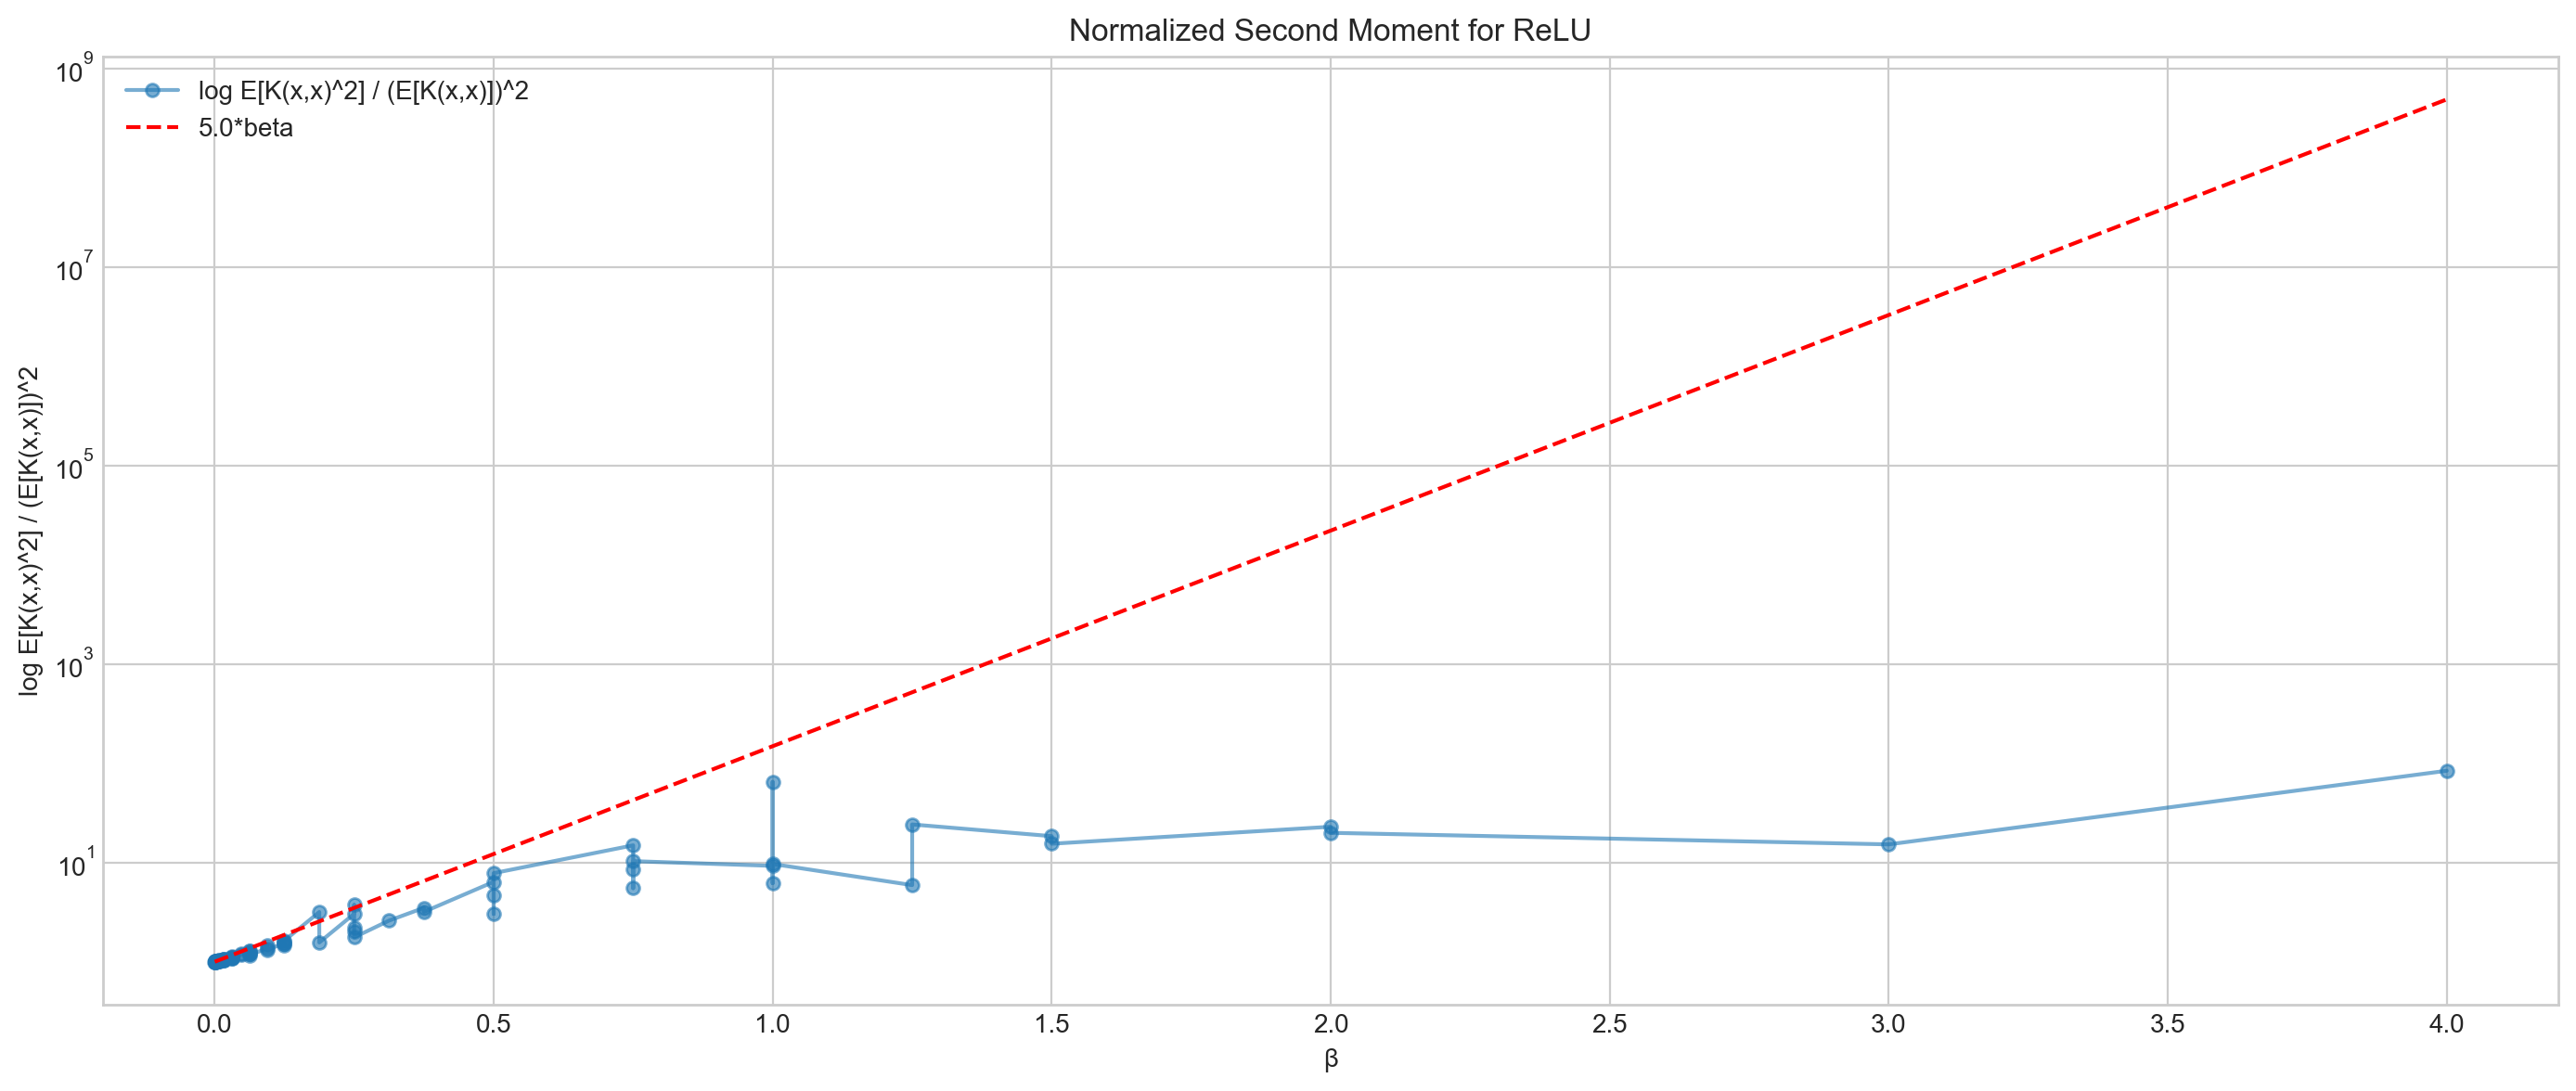

In [38]:
# --- Plot for Stochasticity: E[K^2]/E[K]^2 vs. beta ---
plot_data_stochasticity = []
# Iterate over DataFrame rows as dictionaries
for res_stoch in relu_result.to_dict('records'): 
    beta_val = res_stoch.get("beta")
    emp_norm_sq_moment_val = res_stoch.get("emp_norm_sq_moment")
    
    if beta_val is not None and \
       emp_norm_sq_moment_val is not None and \
       not (isinstance(emp_norm_sq_moment_val, float) and pd.isna(emp_norm_sq_moment_val)): # Use pd.isna for DataFrames
        
        activation_name_stoch = "Unknown"
        config_details_stoch = res_stoch.get("config_details")
        if isinstance(config_details_stoch, dict):
            activation_name_stoch = config_details_stoch.get("ACTIVATION_NAME", "Unknown")

        plot_data_stochasticity.append({
            "beta": beta_val, 
            "emp_norm_sq_moment": emp_norm_sq_moment_val,
            "config_name": res_stoch.get("config_name", "N/A"),
            "activation_name": activation_name_stoch
        })

plot_df_stochasticity = pd.DataFrame(plot_data_stochasticity)
plot_df_stochasticity = plot_df_stochasticity.sort_values(by="beta")

plt.figure(figsize=(14, 6))

plt.plot(plot_df_stochasticity["beta"].values, 
         plot_df_stochasticity["emp_norm_sq_moment"].values, 
         "o-", markersize=5, alpha=0.6, label="log E[K(x,x)^2] / (E[K(x,x)])^2")

relu_plot_df_stoch = plot_df_stochasticity[plot_df_stochasticity["activation_name"] == "ReLU"]
if not relu_plot_df_stoch.empty:
    C_factor_hn = 5.0 
    betas_for_relu_plot_stoch = jnp.array(relu_plot_df_stoch["beta"].values)
    if betas_for_relu_plot_stoch.size > 0:
        theo_scaling_relu = jnp.exp(C_factor_hn * betas_for_relu_plot_stoch)
        plt.plot(betas_for_relu_plot_stoch, 
                 theo_scaling_relu, 
                 "--", color='red', 
                 label=f"{C_factor_hn}*beta")

plt.xlabel("β")
plt.ylabel("log E[K(x,x)^2] / (E[K(x,x)])^2")
plt.title("Normalized Second Moment for ReLU")
plt.legend()
plt.grid(True, which="both")
plt.yscale('log')

plt.tight_layout()
plt.show()

#### Plotting other activation functions

In [39]:
# this loads the files

files = {
    "ReLU": "relu.dill.pkl",
    "GeLU": "gelu.dill.pkl",
    "sigmoid": "sigmoid.dill.pkl"
}

plot_data_stochasticity = []
for activation, filename in files.items():
    pickle_filename = os.path.join(output_directory, filename)
    loaded_results_df = None
    try:
        with open(pickle_filename, 'rb') as f:
            loaded_results_df = dill.load(f)
    except Exception as e:
        print(f"Error loading {filename}: {e}")
        continue
        
    for res_stoch in loaded_results_df.to_dict('records'):
        beta_val = res_stoch.get("beta")
        emp_norm_sq_moment_val = res_stoch.get("emp_norm_sq_moment")
        
        if (beta_val is not None and
            emp_norm_sq_moment_val is not None and
            not (isinstance(emp_norm_sq_moment_val, float) and pd.isna(emp_norm_sq_moment_val))):
            
            activation_name_stoch = activation 
            config_details_stoch = res_stoch.get("config_details")
            if isinstance(config_details_stoch, dict):
                # Override with config_details if available
                activation_name_stoch = config_details_stoch.get("ACTIVATION_NAME", activation)

            plot_data_stochasticity.append({
                "beta": beta_val,
                "emp_norm_sq_moment": emp_norm_sq_moment_val,
                "config_name": res_stoch.get("config_name", "N/A"),
                "activation_name": activation_name_stoch
            })

plot_df_stochasticity = pd.DataFrame(plot_data_stochasticity)
plot_df_stochasticity = plot_df_stochasticity.sort_values(by="beta")

display(plot_df_stochasticity)

,beta,emp_norm_sq_moment,config_name,activation_name
58,0.000244,1.000829,D1_W4096,ReLU
212,0.000244,1.000161,D1_W4096,Sigmoid_like
134,0.000244,1.000944,D1_W4096,Gelu
133,0.000488,1.001348,D1_W2048,Gelu
57,0.000488,1.001192,D1_W2048,ReLU
...,...,...,...,...
6,3.000000,15.229124,D48_W16,ReLU
160,3.000000,1.018831,D48_W16,Sigmoid_like
7,4.000000,83.989090,D64_W16,ReLU
161,4.000000,1.018208,D64_W16,Sigmoid_like


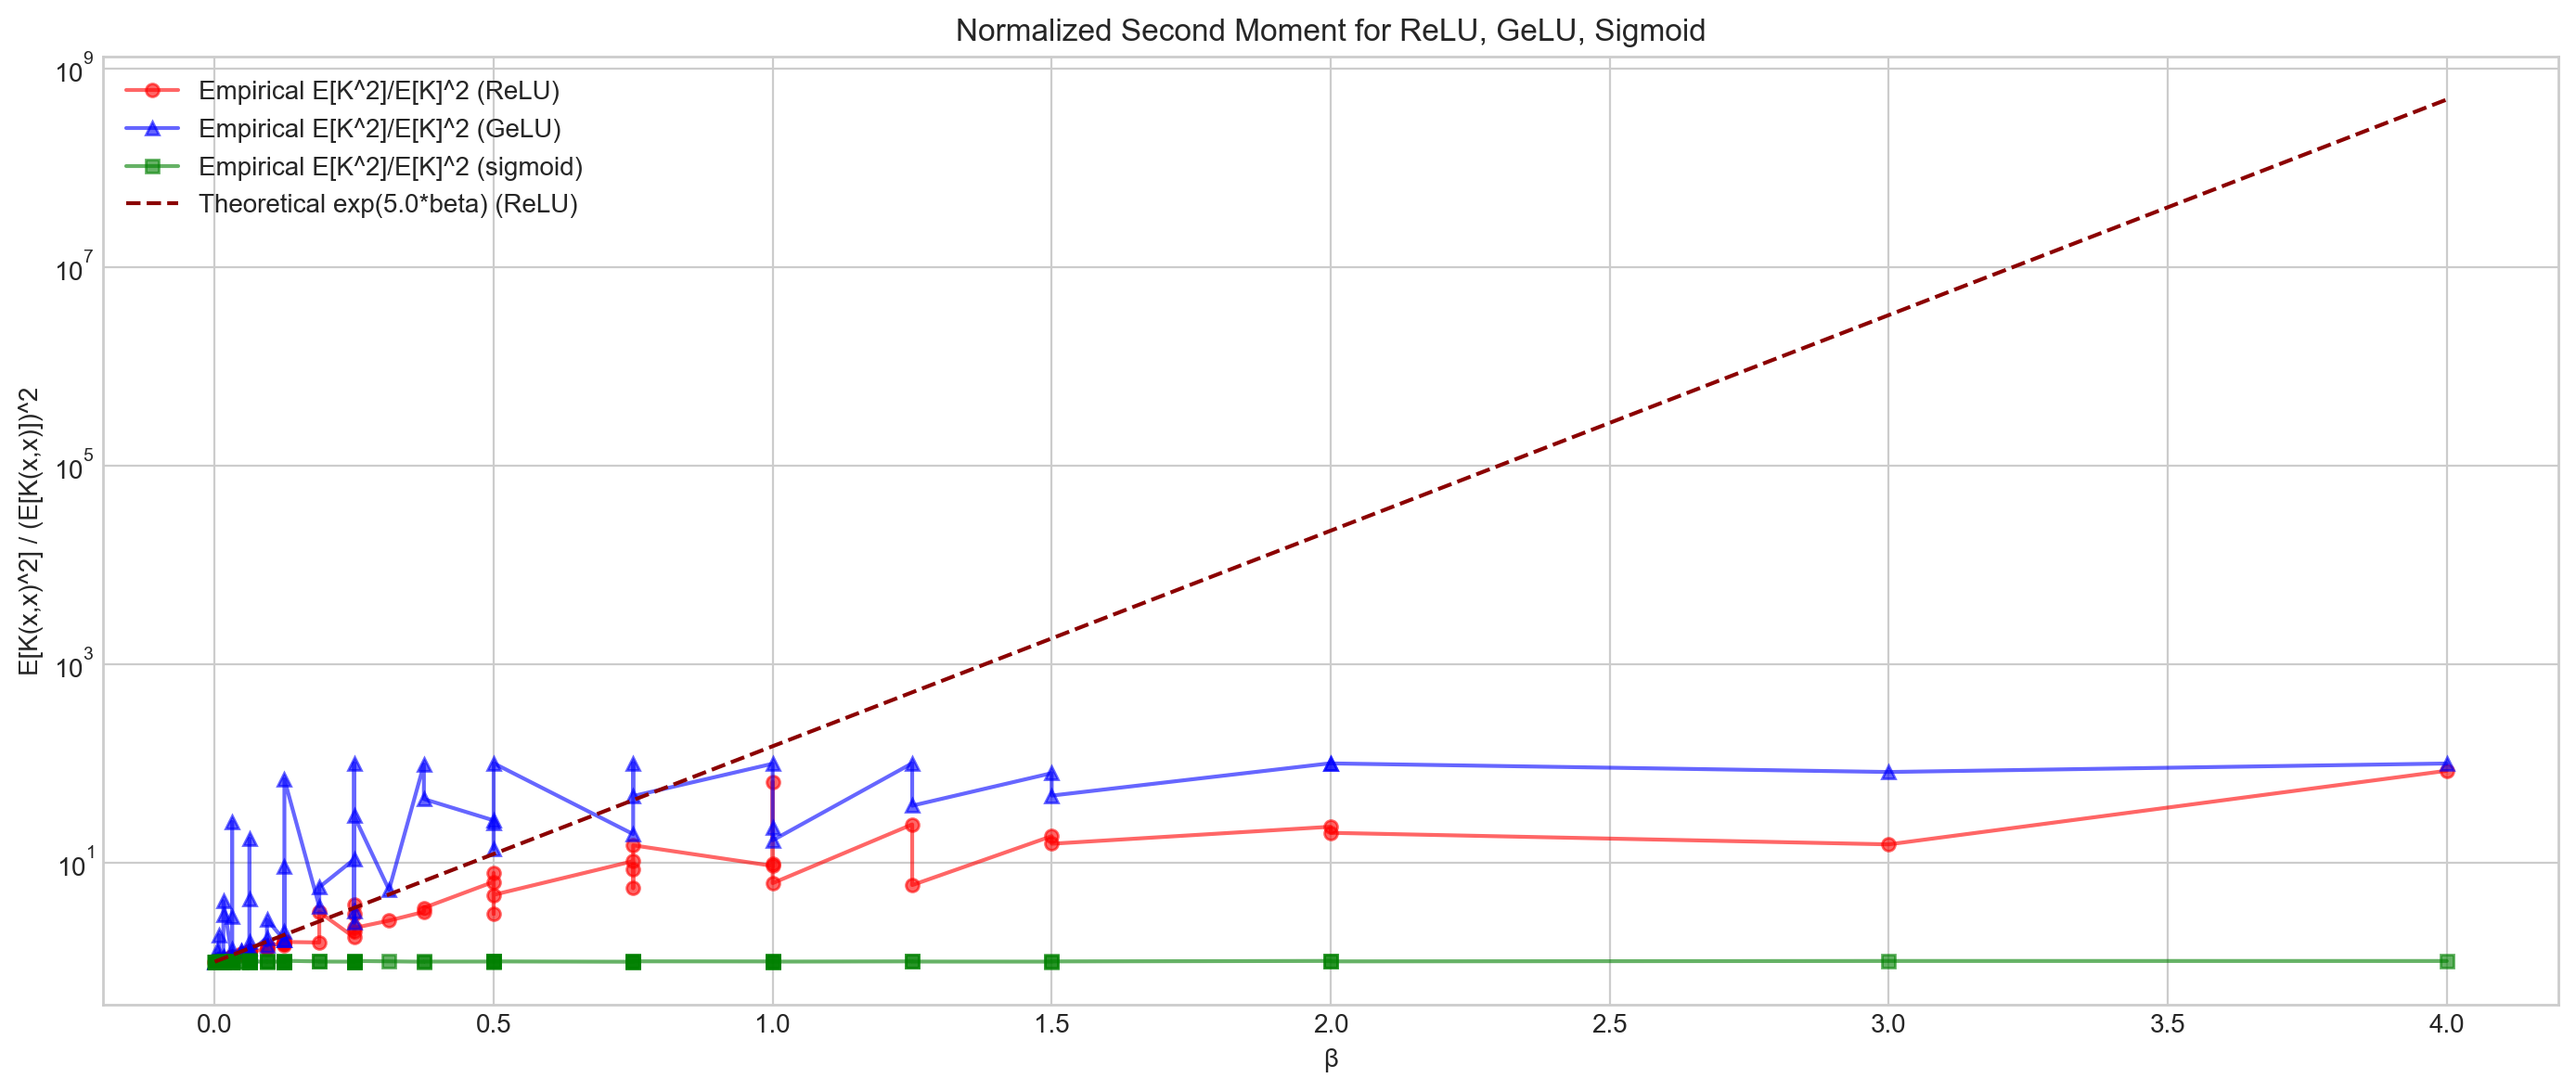

In [40]:
activation_styles = {
    "ReLU": {"color": "red", "marker": "o", "label": "ReLU"},
    "Gelu": {"color": "blue", "marker": "^", "label": "GeLU"},
    "Sigmoid_like": {"color": "green", "marker": "s", "label": "sigmoid"}
}

# Plotting
plt.figure(figsize=(14, 6))

# Subplot 1: Normalized Second Moment
for activation in activation_styles:
    df_subset = plot_df_stochasticity[plot_df_stochasticity["activation_name"] == activation]
    if not df_subset.empty:
        plt.plot(
            df_subset["beta"].values,
            df_subset["emp_norm_sq_moment"].values,
            marker=activation_styles[activation]["marker"],
            color=activation_styles[activation]["color"],
            markersize=5,
            alpha=0.6,
            label=f"Empirical E[K^2]/E[K]^2 ({activation_styles[activation]['label']})"
        )

# Add theoretical curve for ReLU
relu_plot_df_stoch = plot_df_stochasticity[plot_df_stochasticity["activation_name"] == "ReLU"]
if not relu_plot_df_stoch.empty:
    C_factor_hn = 5.0
    betas_for_relu_plot_stoch = jnp.array(relu_plot_df_stoch["beta"].values)
    if betas_for_relu_plot_stoch.size > 0:
        theo_scaling_relu = jnp.exp(C_factor_hn * betas_for_relu_plot_stoch)
        plt.plot(
            betas_for_relu_plot_stoch,
            theo_scaling_relu,
            "--",
            color='darkred',
            label=f"Theoretical exp({C_factor_hn}*beta) (ReLU)"
        )

plt.xlabel("β")
plt.ylabel("E[K(x,x)^2] / (E[K(x,x)])^2")
plt.title("Normalized Second Moment for ReLU, GeLU, Sigmoid")
plt.legend()
plt.grid(True, which="both")
plt.yscale('log')

plt.tight_layout()
plt.show()

##### Zoomed in around the origin

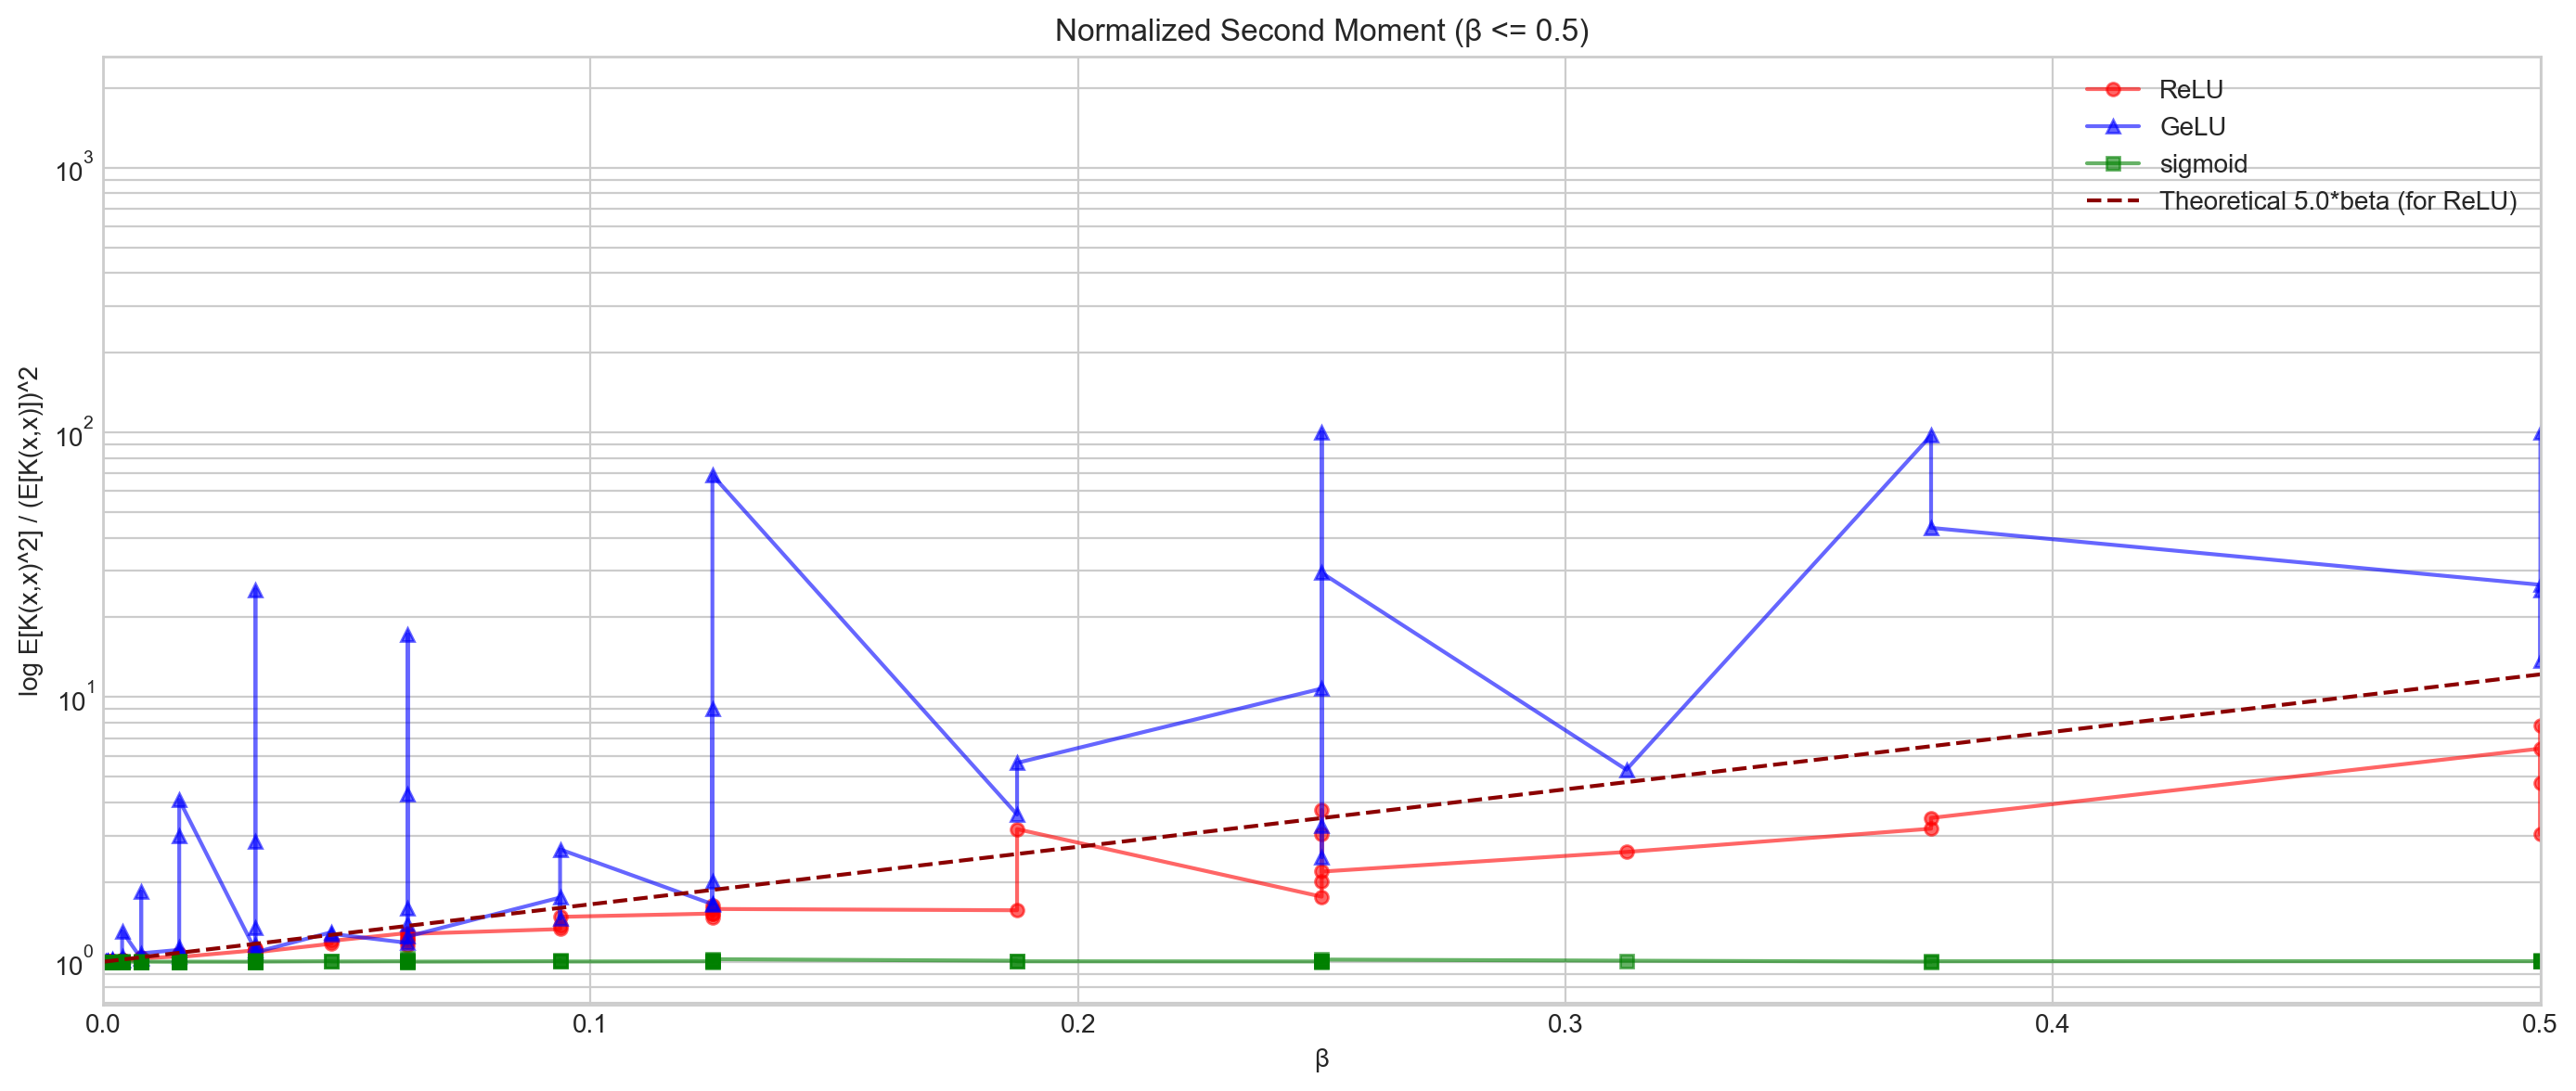

In [41]:
plt.figure(figsize=(14, 6))
BETA_THRES = 0.5

for activation in activation_styles:
    df_subset = plot_df_stochasticity[plot_df_stochasticity["activation_name"] == activation]
    df_subset_zoomed = df_subset[df_subset["beta"] <= BETA_THRES]
    if not df_subset_zoomed.empty:
        plt.plot(
            df_subset_zoomed["beta"].values,
            df_subset_zoomed["emp_norm_sq_moment"].values,
            marker=activation_styles[activation]["marker"],
            color=activation_styles[activation]["color"],
            markersize=5,
            alpha=0.6,
            label=f"{activation_styles[activation]['label']}"
        )

# Add theoretical curve for ReLU (zoomed)
relu_plot_df_stoch = plot_df_stochasticity[plot_df_stochasticity["activation_name"] == "ReLU"]
relu_plot_df_stoch_zoomed = relu_plot_df_stoch[relu_plot_df_stoch["beta"] <= 1.5]
if not relu_plot_df_stoch_zoomed.empty:
    C_factor_hn = 5.0
    betas_for_relu_plot_stoch = jnp.array(relu_plot_df_stoch_zoomed["beta"].values)
    if betas_for_relu_plot_stoch.size > 0:
        theo_scaling_relu = jnp.exp(C_factor_hn * betas_for_relu_plot_stoch)
        plt.plot(
            betas_for_relu_plot_stoch,
            theo_scaling_relu,
            "--",
            color='darkred',
            label=f"Theoretical {C_factor_hn}*beta (for ReLU)"
        )

plt.xlabel("β")
plt.ylabel("log E[K(x,x)^2] / (E[K(x,x)])^2")
plt.title(f"Normalized Second Moment (β <= {BETA_THRES})")
plt.legend()
plt.grid(True, which="both")
plt.yscale('log')
plt.xlim(0, BETA_THRES)

plt.tight_layout()
plt.show()

In [42]:
activations = ["ReLU", "Gelu", "Sigmoid_like"]

for activation in activations:
    df_subset = plot_df_stochasticity[plot_df_stochasticity["activation_name"] == activation]
    if not df_subset.empty:
        activation_max = df_subset["emp_norm_sq_moment"].max()
        activation_min = df_subset["emp_norm_sq_moment"].min()
    else:
        activation_max = activation_min = None
    
    print(f"{activation} Values:")
    print(f"Max: {activation_max}")
    print(f"Min: {activation_min}")
    print()

ReLU Values:
Max: 83.98908996582031
Min: 1.0008286237716675

Gelu Values:
Max: 100.0
Min: 1.0009443759918213

Sigmoid_like Values:
Max: 1.026949167251587
Min: 1.0000667572021484



! Sigmoid is very stable

### Theorem 2

#### Expectation of SGD update
 $$ \Delta K_{\mathcal{N}}(x,x) = K_{\mathcal{N}}(x,x; \theta_{t_1}) - K_{\mathcal{N}}(x,x; \theta_{t_0}) $$
- non-zero if $\beta > 0$, indicating NTK evolution
- stored in `emp_E_Delta_Kxx`

---

#### Target result
$$ \frac{\mathbb{E}[\Delta K_{\mathcal{N}}(x,x)]}{\mathbb{E}[K_{\mathcal{N}}(x,x)]} \propto \frac{d \cdot \beta}{n_0} \cdot \exp(C \cdot \beta) \cdot \lambda_{lr}$$
> Interpretation: The average *relative* change in $K_{\mathcal{N}}(x,x)$ after one SGD step.


#### Plotting ReLU


--- Plotting NTK Evolution: Relative Change vs. Theoretical Scaling ---
Number of ReLU configurations with valid data for Delta K plot: 78
Data for Delta K plot (first 5 rows):


,beta,emp_relative_delta_K,theo_scaling_term_delta_K_relu,config_name
0,0.0625,-0.000216,0.000171,D1_W16
1,0.1250,-0.000696,0.000701,D2_W16
2,0.2500,-0.002128,0.004363,D4_W16
3,0.5000,-0.030744,0.054821,D8_W16
4,1.0000,-0.108752,2.523024,D16_W16


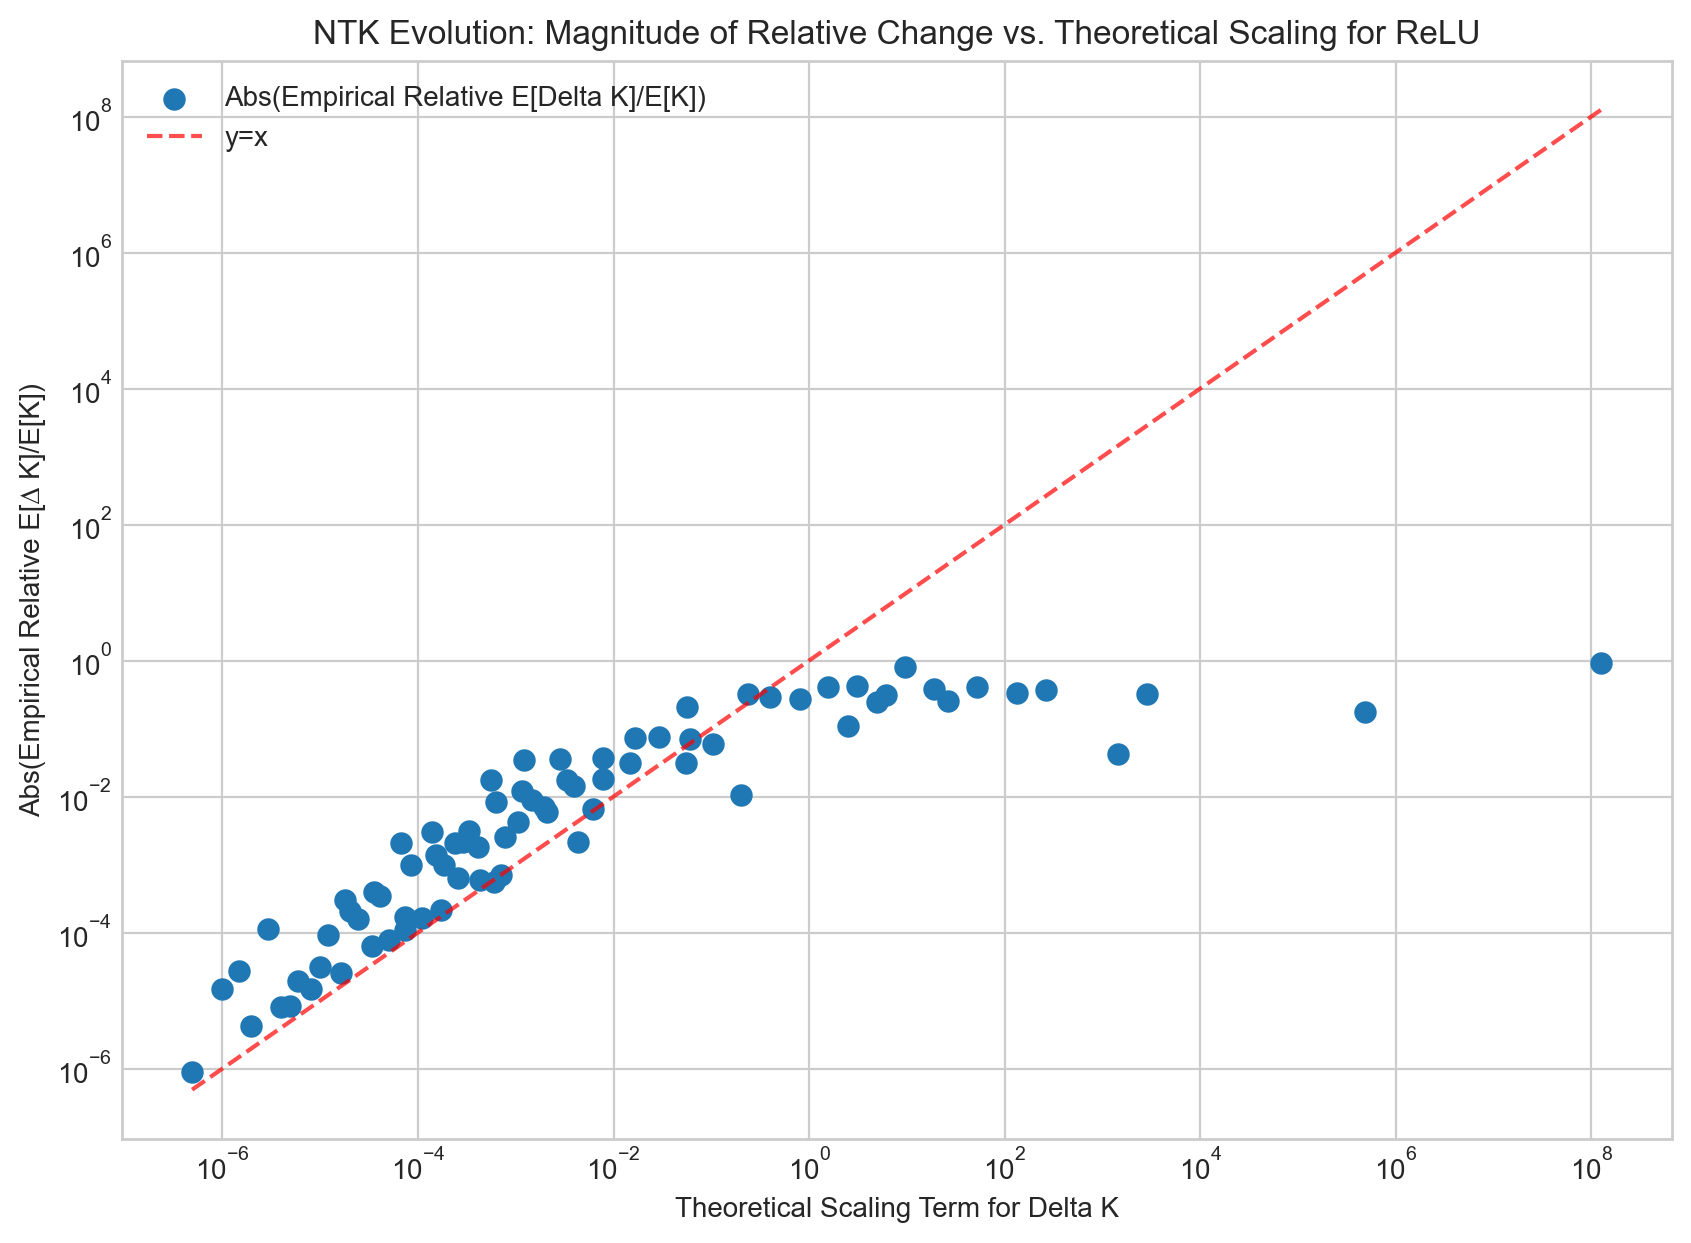

In [44]:
# --- Plot for NTK Evolution: E[Delta K]/E[K] vs theoretical scaling term ---
print("\n--- Plotting NTK Evolution: Relative Change vs. Theoretical Scaling ---")
plot_data_delta_k = []
# Iterate over DataFrame rows as dictionaries
for res_delta in relu_result.to_dict('records'): 
    activation_name_delta = "Unknown"
    config_details_delta = res_delta.get("config_details")
    if isinstance(config_details_delta, dict):
        activation_name_delta = config_details_delta.get("ACTIVATION_NAME", "Unknown")
    
    is_relu_config_delta = (activation_name_delta == "ReLU")

    beta_dk = res_delta.get("beta")
    emp_rel_dk = res_delta.get("emp_relative_delta_K")
    theo_scale_dk = res_delta.get("theo_scaling_term_delta_K_relu")

    if beta_dk is not None and \
       emp_rel_dk is not None and \
       not (isinstance(emp_rel_dk, float) and pd.isna(emp_rel_dk)) and \
       theo_scale_dk is not None and \
       is_relu_config_delta: 
        plot_data_delta_k.append({
            "beta": beta_dk,
            "emp_relative_delta_K": emp_rel_dk,
            "theo_scaling_term_delta_K_relu": theo_scale_dk or 0,
            "config_name": res_delta.get("config_name", "N/A")
        })
plot_df_delta_k = pd.DataFrame(plot_data_delta_k)

print(f"Number of ReLU configurations with valid data for Delta K plot: {len(plot_df_delta_k)}")
if not plot_df_delta_k.empty:
    print("Data for Delta K plot (first 5 rows):")
    from IPython.display import display
    display(plot_df_delta_k.head())

    plot_df_delta_k = plot_df_delta_k.sort_values(by="theo_scaling_term_delta_K_relu")
    
    x_plot_values_dk = jnp.asarray(plot_df_delta_k["theo_scaling_term_delta_K_relu"].values)
    y_plot_values_dk_abs = jnp.abs(jnp.asarray(plot_df_delta_k["emp_relative_delta_K"].values))
    config_names_dk_plot = plot_df_delta_k["config_name"].values

    valid_log_indices_dk_x = x_plot_values_dk > 1e-9 
    valid_log_indices_dk_y = y_plot_values_dk_abs > 1e-9 
    valid_log_indices_dk = valid_log_indices_dk_x & valid_log_indices_dk_y
    
    x_plot_final_dk = x_plot_values_dk[valid_log_indices_dk]
    y_plot_final_dk = y_plot_values_dk_abs[valid_log_indices_dk]
    names_final_dk = config_names_dk_plot[valid_log_indices_dk]

    if x_plot_final_dk.size > 0:
        plt.figure(figsize=(10, 7)) 
        plt.scatter(x_plot_final_dk, 
                    y_plot_final_dk, 
                    label="Abs(Empirical Relative E[Delta K]/E[K])",
                    s=50) 

        # uncomment to see the names of each configuration
        # for i, txt in enumerate(names_final_dk):
        #     plt.annotate(txt, (x_plot_final_dk[i], y_plot_final_dk[i]),
        #                  textcoords="offset points", xytext=(0,10), ha='center', fontsize=9)

        valid_theo_dk = x_plot_final_dk[jnp.isfinite(x_plot_final_dk)]
        valid_emp_dk = y_plot_final_dk[jnp.isfinite(y_plot_final_dk)]

        if valid_theo_dk.size > 0 and valid_emp_dk.size > 0:
            min_val_plot = min(valid_theo_dk.min().item(), valid_emp_dk.min().item())
            max_val_plot = max(valid_theo_dk.max().item(), valid_emp_dk.max().item())
        
            if not (jnp.isnan(min_val_plot) or jnp.isnan(max_val_plot) or 
                    jnp.isinf(min_val_plot) or jnp.isinf(max_val_plot) or
                    abs(min_val_plot - max_val_plot) < 1e-9): 
                plt.plot([min_val_plot, max_val_plot], [min_val_plot, max_val_plot], 
                         'r--', alpha=0.7, label="y=x")

        plt.xlabel("Theoretical Scaling Term for Delta K")
        plt.ylabel("Abs(Empirical Relative E[∆ K]/E[K])")
        plt.title("NTK Evolution: Magnitude of Relative Change vs. Theoretical Scaling for ReLU")
        plt.xscale('log')
        plt.yscale('log')
        plt.legend()
        plt.grid(True, which="both")
        plt.show()
    else:
        print("No positive empirical relative Delta K values (or positive theoretical scaling terms) available to plot on log scale for Delta K.")
else:
    print("No ReLU data available to plot NTK evolution scaling vs theoretical term (plot_df_delta_k is empty).")

##### Analyzing configurations that deviate from result ***significantly***
Calculate z-score to filter out configurations that deviate from theoretical result

--- Found 4 Statistically Significant Outlier(s) ---


,config_name,beta,deviation_z_score
20,D64_W32,2.0,-2.322986
5,D32_W16,2.0,-2.672388
6,D48_W16,3.0,-3.810848
7,D64_W16,4.0,-4.835678


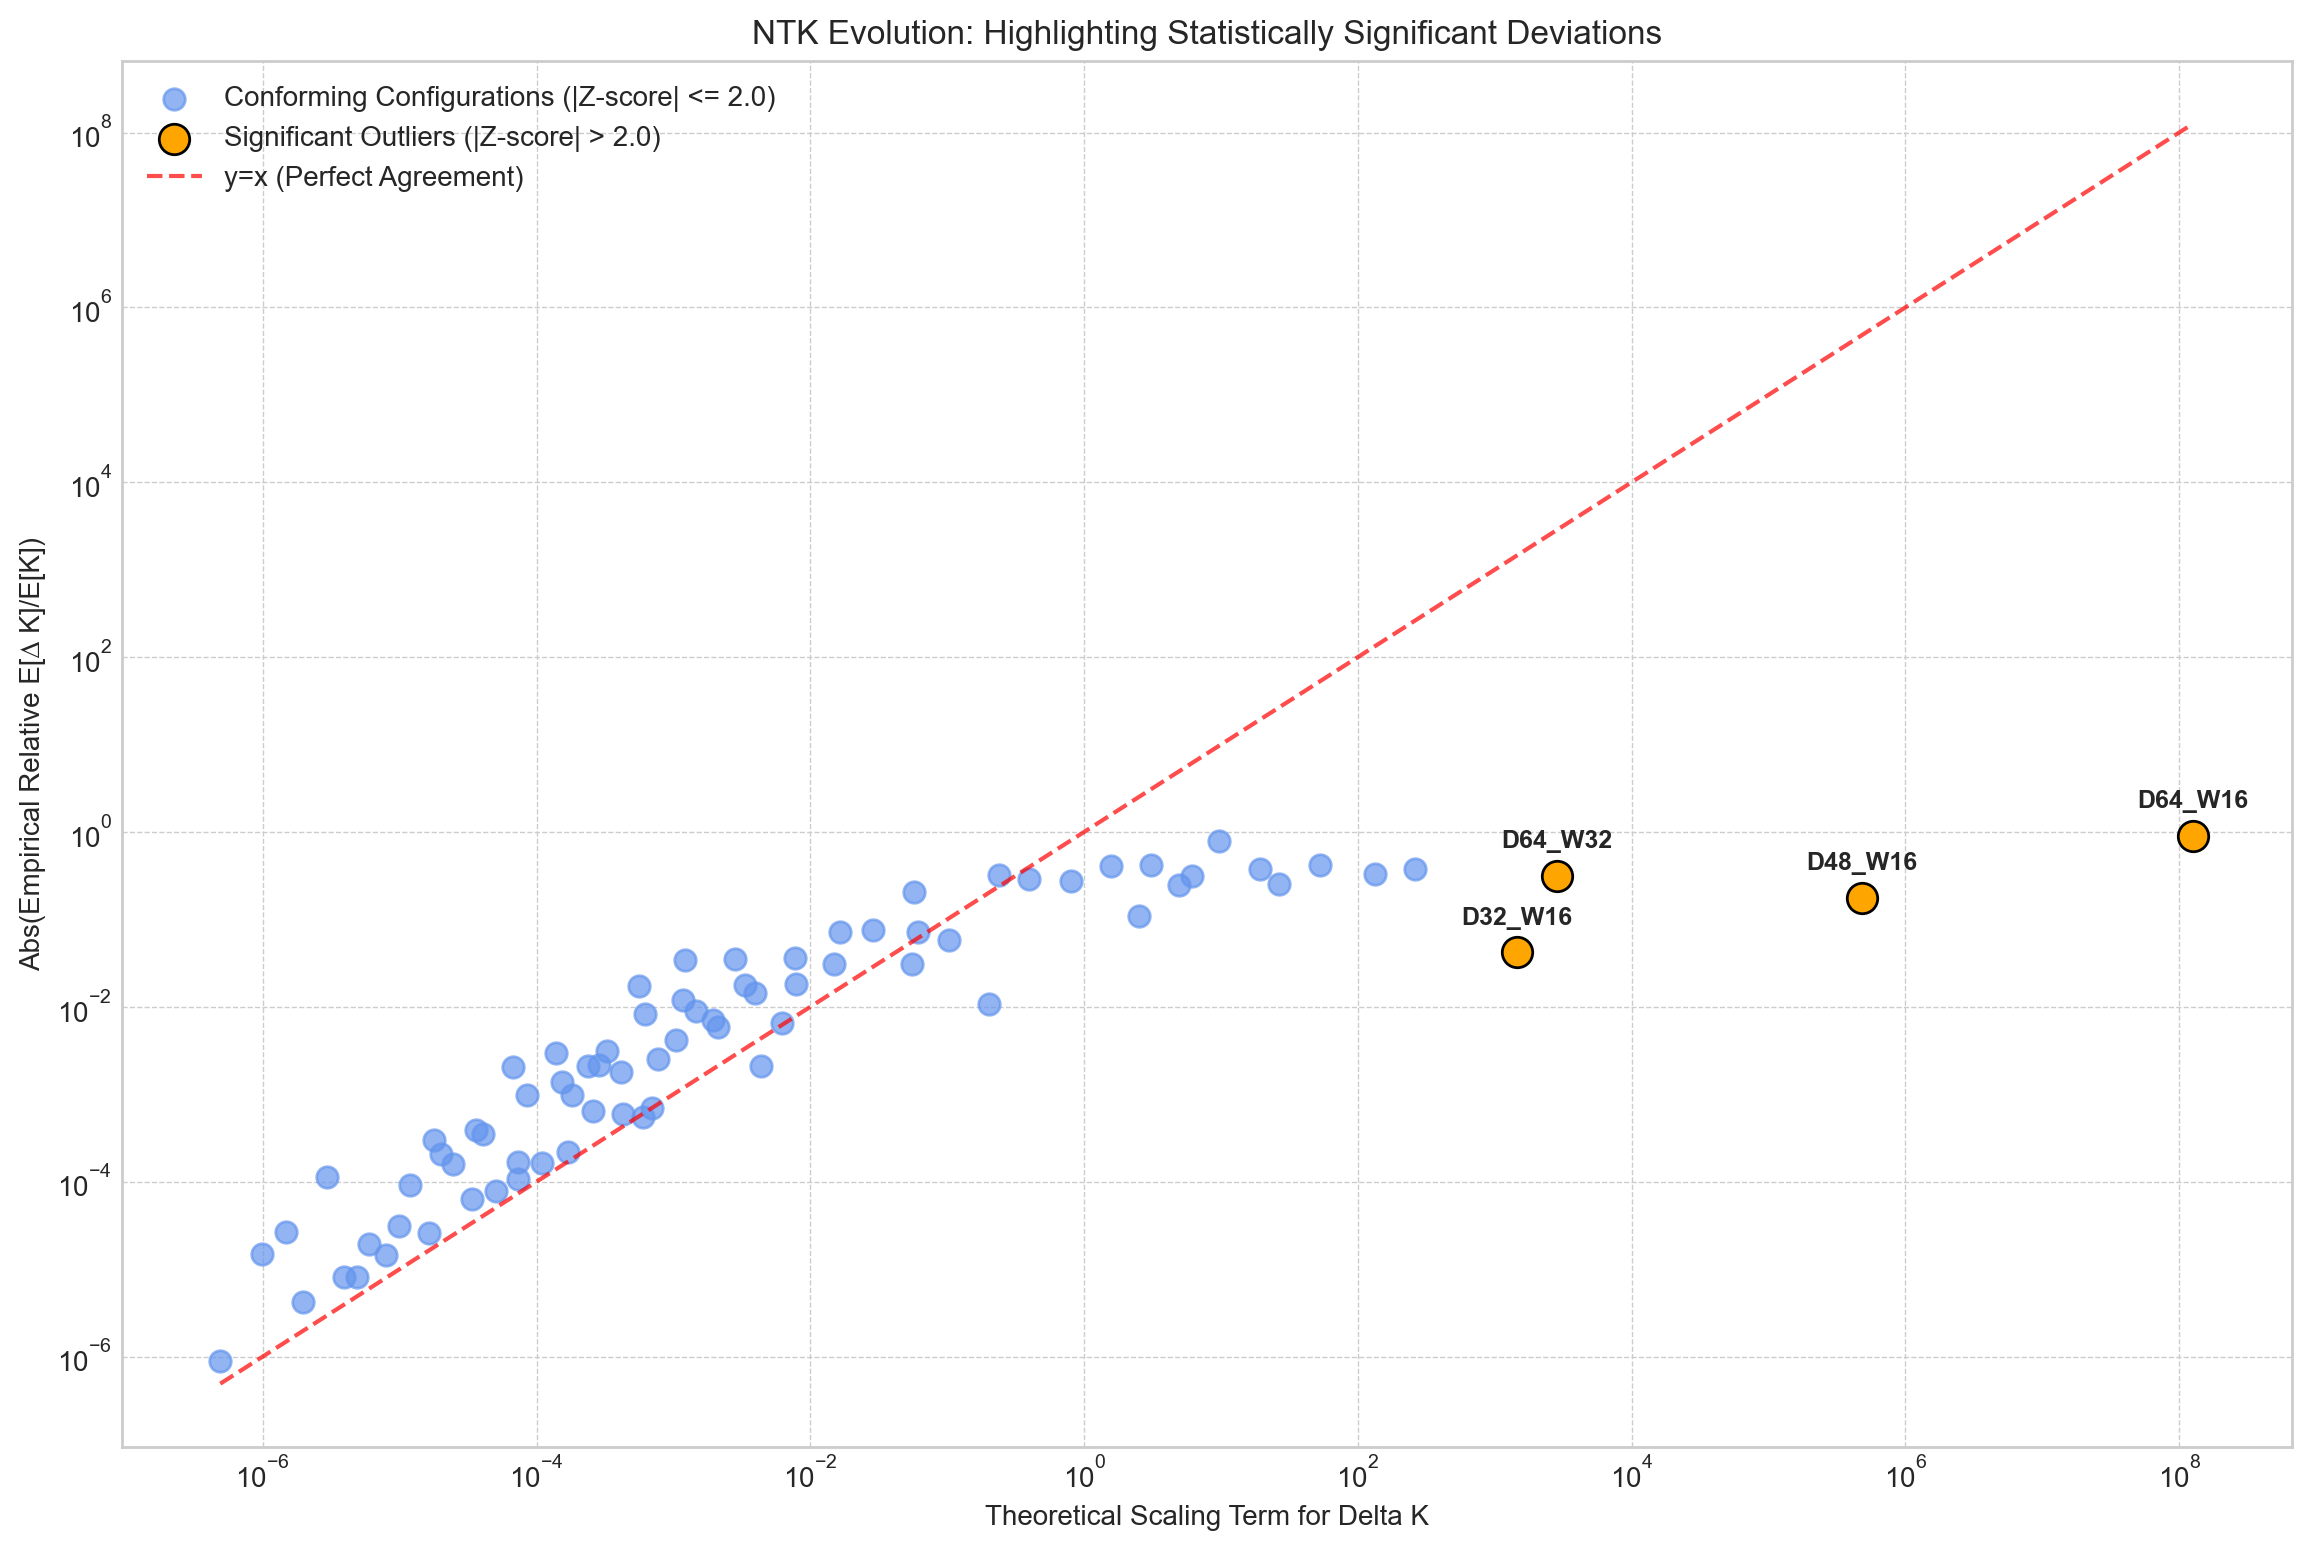

In [80]:
# --- 1. Calculate Z-Score for Deviation ---
epsilon = 1e-12
plot_df_delta_k['deviation_ratio'] = (
    np.abs(plot_df_delta_k['emp_relative_delta_K']) /
    (plot_df_delta_k['theo_scaling_term_delta_K_relu'] + epsilon)
)
#  log of the ratio centers the distribution around 0
plot_df_delta_k['log_deviation_ratio'] = np.log(plot_df_delta_k['deviation_ratio'])

mean_log_ratio = plot_df_delta_k['log_deviation_ratio'].mean()
std_log_ratio = plot_df_delta_k['log_deviation_ratio'].std()

plot_df_delta_k['deviation_z_score'] = (
    (plot_df_delta_k['log_deviation_ratio'] - mean_log_ratio) / std_log_ratio
)

# identify outliers based on z-score
z_score_threshold = 2.0
plot_df_delta_k['is_outlier'] = np.abs(plot_df_delta_k['deviation_z_score']) > z_score_threshold

normal_points = plot_df_delta_k[~plot_df_delta_k['is_outlier']]
outlier_points = plot_df_delta_k[plot_df_delta_k['is_outlier']]

print(f"--- Found {len(outlier_points)} Statistically Significant Outlier(s) ---")
if not outlier_points.empty:
    display(outlier_points[['config_name', 'beta', 'deviation_z_score']].sort_values(by='deviation_z_score', ascending=False))


plt.figure(figsize=(14, 9))

# Plot the normal points
plt.scatter(
    jnp.asarray(normal_points["theo_scaling_term_delta_K_relu"].values),
    jnp.abs(jnp.asarray(normal_points["emp_relative_delta_K"].values)),
    label=f"Conforming Configurations (|Z-score| <= {z_score_threshold})",
    s=60,
    color='cornflowerblue',
    alpha=0.7
)

# Plot the outlier points
if not outlier_points.empty:
    plt.scatter(
        jnp.asarray(outlier_points["theo_scaling_term_delta_K_relu"].values),
        jnp.abs(jnp.asarray(outlier_points["emp_relative_delta_K"].values)),
        label=f"Significant Outliers (|Z-score| > {z_score_threshold})",
        s=120,
        color='orange',
        edgecolor='black',
        linewidth=1.0
    )
    # Annotate the outliers
    for i, row in outlier_points.iterrows():
        plt.annotate(
            f"{row['config_name']}",
            (row["theo_scaling_term_delta_K_relu"], np.abs(row["emp_relative_delta_K"])),
            textcoords="offset points",
            xytext=(0,10),
            ha='center',
            fontsize=9,
            fontweight='bold'
        )

# Plot the y=x reference line
all_x = plot_df_delta_k["theo_scaling_term_delta_K_relu"].values
all_y = np.abs(plot_df_delta_k["emp_relative_delta_K"].values)
valid_indices = (all_x > epsilon) & (all_y > epsilon)
valid_x = all_x[valid_indices]
valid_y = all_y[valid_indices]
if valid_x.size > 0 and valid_y.size > 0:
    min_val_plot = min(valid_x.min(), valid_y.min())
    max_val_plot = max(valid_x.max(), valid_y.max())
    plt.plot([min_val_plot, max_val_plot], [min_val_plot, max_val_plot], 'r--', alpha=0.7, label="y=x (Perfect Agreement)")

plt.xlabel("Theoretical Scaling Term for Delta K")
plt.ylabel("Abs(Empirical Relative E[∆ K]/E[K])")
plt.title("NTK Evolution: Highlighting Statistically Significant Deviations")
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.grid(True, which="both", linestyle='--', linewidth=0.5)
plt.show()

#### Plotting other activation functions

In [81]:
# this loads the files

files = {
    "ReLU": "relu.dill.pkl",
    "GeLU": "gelu.dill.pkl",
    "sigmoid": "sigmoid.dill.pkl"
}

plot_data_delta_k = []
for activation, filename in files.items():
    pickle_filename = os.path.join(output_directory, filename)
    loaded_results_df = None
    try:
        with open(pickle_filename, 'rb') as f:
            loaded_results_df = dill.load(f)
    except Exception as e:
        print(f"Error loading {filename}: {e}")
        continue
        
    for res_delta in loaded_results_df.to_dict('records'):
        activation_name_delta = "Unknown"
        config_details_delta = res_delta.get("config_details")
        if isinstance(config_details_delta, dict):
            activation_name_delta = config_details_delta.get("ACTIVATION_NAME", "Unknown")
                
        beta_dk = res_delta.get("beta")
        emp_rel_dk = res_delta.get("emp_relative_delta_K")
    
        if beta_dk is not None and \
           emp_rel_dk is not None and \
           not (isinstance(emp_rel_dk, float) and pd.isna(emp_rel_dk)) and \
           theo_scale_dk is not None:
            plot_data_delta_k.append({
                "beta": beta_dk,
                "emp_relative_delta_K": emp_rel_dk,
                "config_name": res_delta.get("config_name", "N/A"),
                "activation_name": activation_name_delta,
                "config_details": config_details_delta,
            })

plot_df_delta_k = pd.DataFrame(plot_data_delta_k)
plot_df_delta_k = plot_df_delta_k.sort_values(by="beta")

display(plot_df_delta_k)

,beta,emp_relative_delta_K,config_name,activation_name,config_details
135,0.000244,-1.024055e-06,D1_W4096,Gelu,"{'name': 'D1_W4096', 'HIDDEN_LAYERS': 1, 'HIDD..."
58,0.000244,-8.959356e-07,D1_W4096,ReLU,"{'name': 'D1_W4096', 'HIDDEN_LAYERS': 1, 'HIDD..."
213,0.000244,-4.759853e-08,D1_W4096,Sigmoid_like,"{'name': 'D1_W4096', 'HIDDEN_LAYERS': 1, 'HIDD..."
62,0.000488,-2.680740e-05,D2_W4096,ReLU,"{'name': 'D2_W4096', 'HIDDEN_LAYERS': 2, 'HIDD..."
57,0.000488,-1.500389e-05,D1_W2048,ReLU,"{'name': 'D1_W2048', 'HIDDEN_LAYERS': 1, 'HIDD..."
...,...,...,...,...,...
6,3.000000,1.766149e-01,D48_W16,ReLU,"{'name': 'D48_W16', 'HIDDEN_LAYERS': 48, 'HIDD..."
161,3.000000,-5.996671e-06,D48_W16,Sigmoid_like,"{'name': 'D48_W16', 'HIDDEN_LAYERS': 48, 'HIDD..."
162,4.000000,-6.323482e-06,D64_W16,Sigmoid_like,"{'name': 'D64_W16', 'HIDDEN_LAYERS': 64, 'HIDD..."
85,4.000000,0.000000e+00,D64_W16,Gelu,"{'name': 'D64_W16', 'HIDDEN_LAYERS': 64, 'HIDD..."


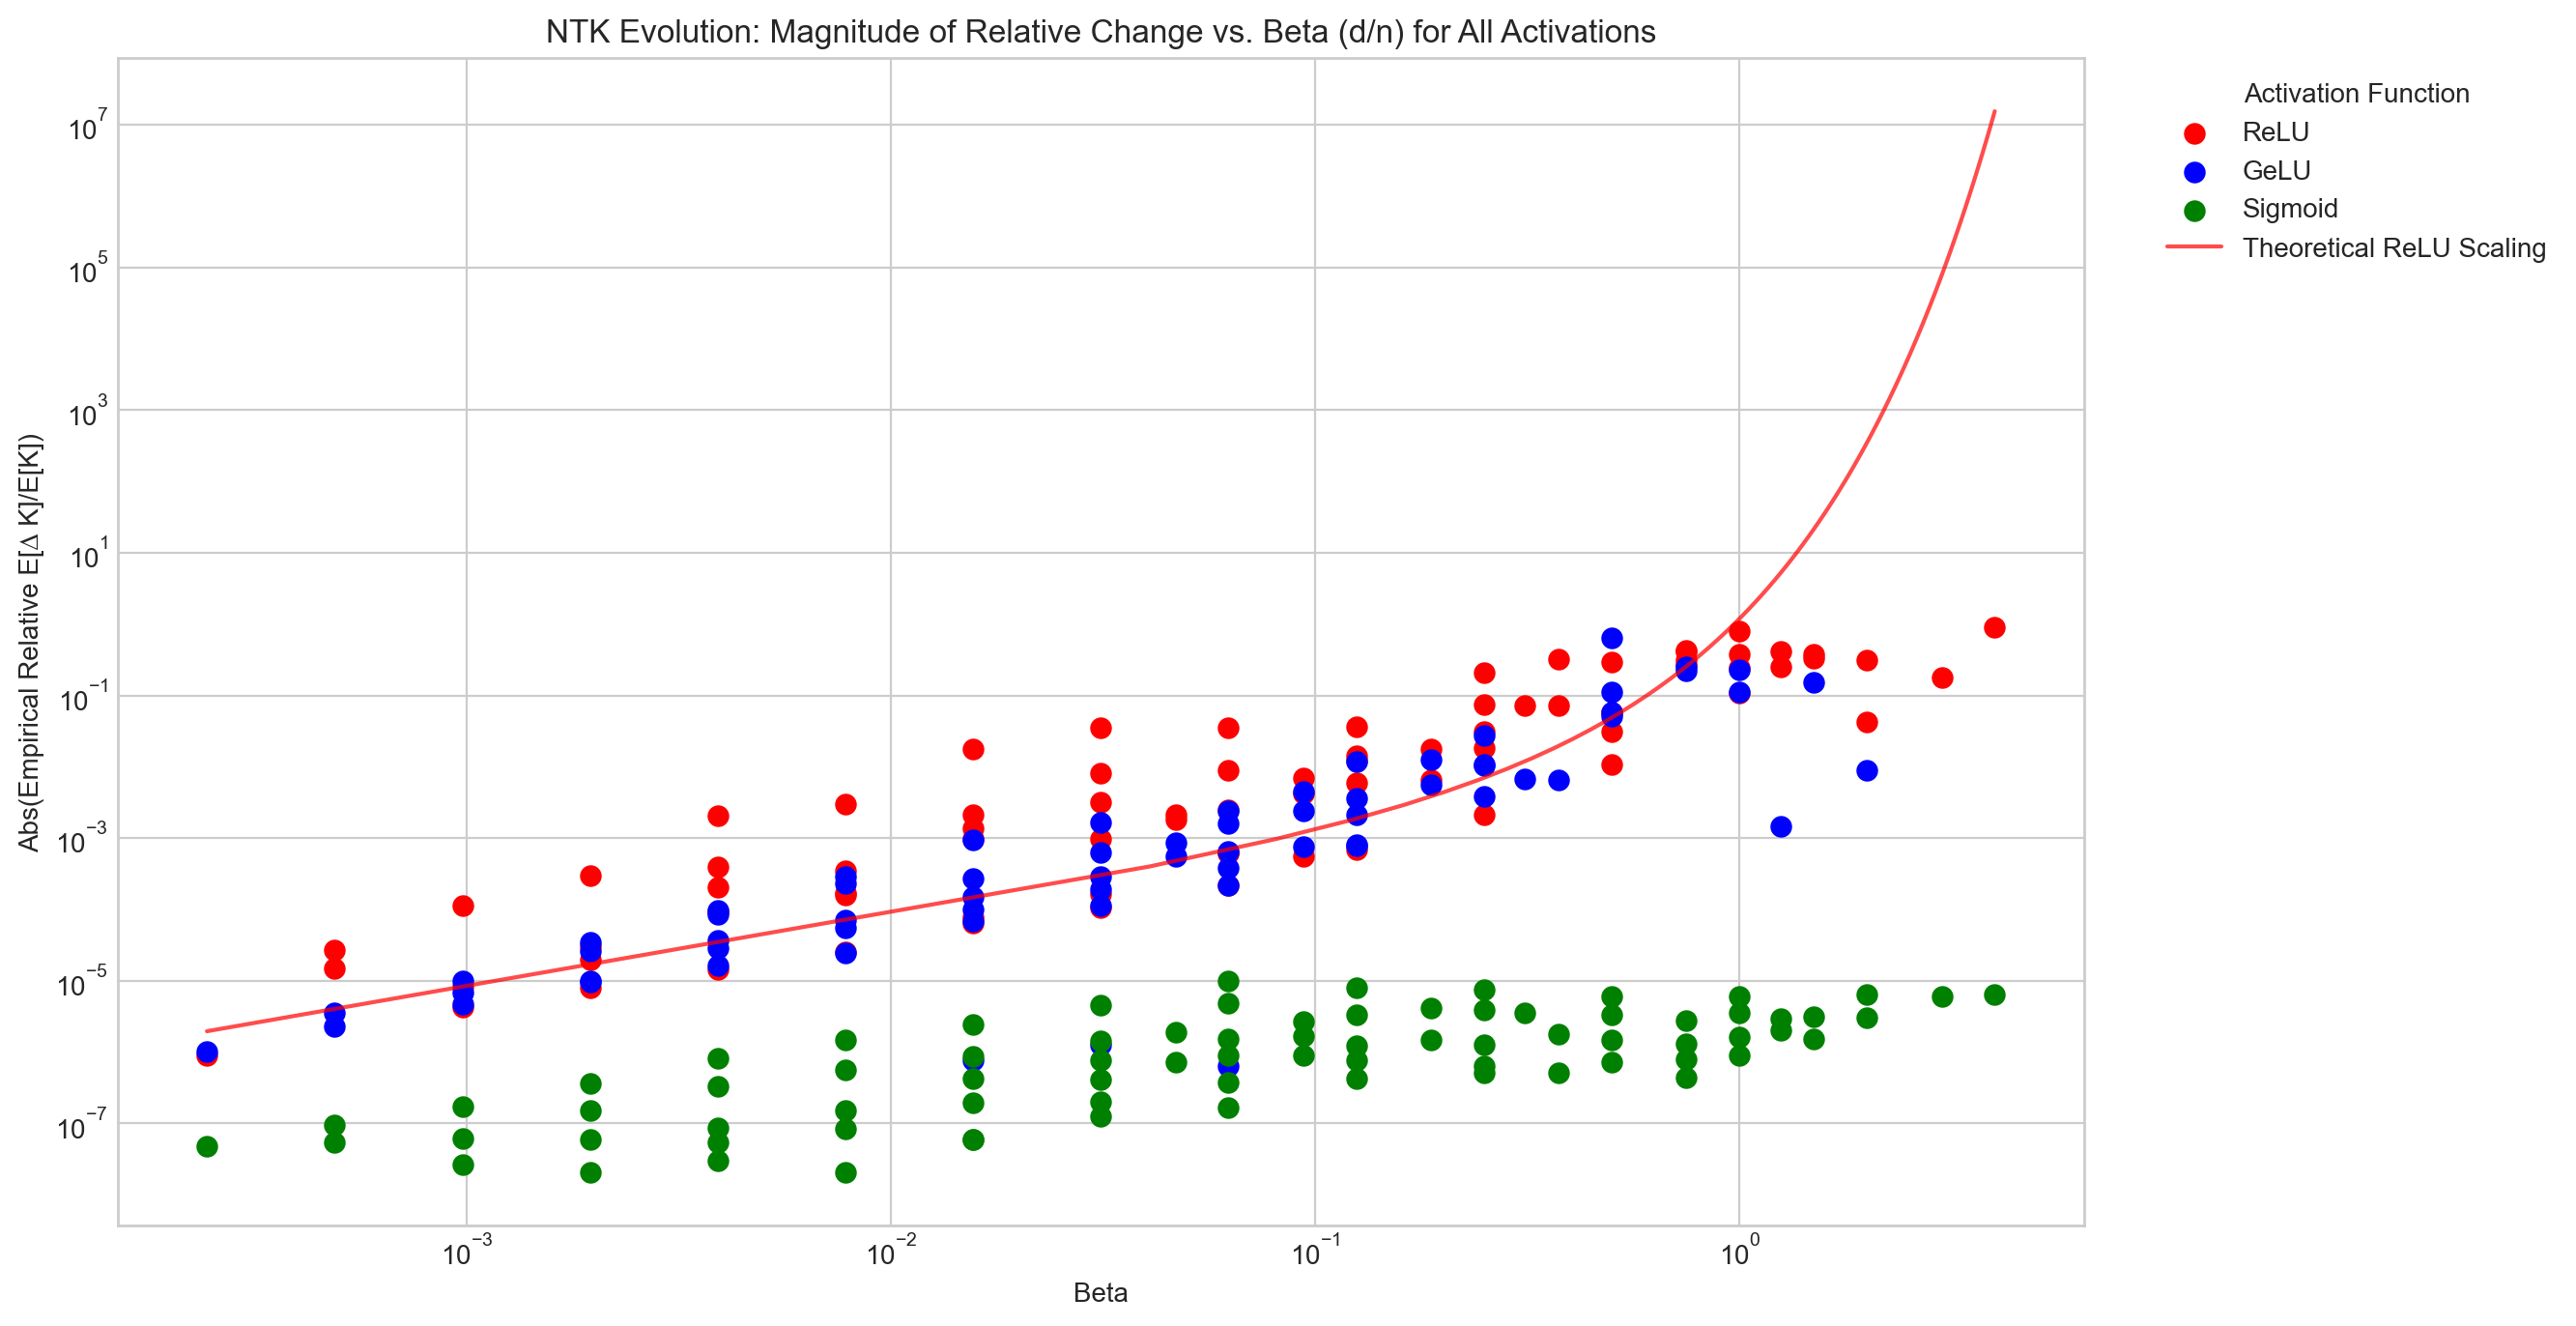

In [83]:
activation_styles = {
    "ReLU": {"color": "red", "marker": "o", "label": "ReLU"},
    "Gelu": {"color": "blue", "marker": "o", "label": "GeLU"},
    "Sigmoid_like": {"color": "green", "marker": "o", "label": "Sigmoid"}
}

plot_data_delta_k = plot_df_delta_k.copy()

plot_data_delta_k['depth'] = plot_data_delta_k['config_name'].str.extract(r'D(\d+)_W(\d+)').iloc[:, 0].astype(float)
plot_data_delta_k['width'] = plot_data_delta_k['config_name'].str.extract(r'D(\d+)_W(\d+)').iloc[:, 1].astype(float)

# Extract input dimension (n0) from config_details if available, or assume a default (e.g., 1 if not specified)
plot_data_delta_k['n0'] = plot_data_delta_k['config_details'].apply(
    lambda x: x.get('INPUT_DIM', 1) if isinstance(x, dict) else 1
).astype(float)

# Compute beta = d/n for each configuration
plot_data_delta_k['beta'] = plot_data_delta_k.apply(
    lambda row: row['depth'] / row['width'] if row['depth'] is not None and row['width'] is not None and row['width'] != 0 else None,
    axis=1
)

# Filter out rows where beta or emp_relative_delta_K is None or NaN
plot_data_delta_k = plot_data_delta_k.dropna(subset=['beta', 'emp_relative_delta_K'])

# Sort by beta for consistent plotting
plot_data_delta_k = plot_data_delta_k.sort_values(by="beta")

# Extract plot values
beta_values = jnp.asarray(plot_data_delta_k["beta"].values)
y_plot_values_dk_abs = jnp.abs(jnp.asarray(plot_data_delta_k["emp_relative_delta_K"].values))
config_names_dk_plot = plot_data_delta_k["config_name"].values
activation_names_dk = plot_data_delta_k["activation_name"].values
depth_values = jnp.asarray(plot_data_delta_k["depth"].values)
n0_values = jnp.asarray(plot_data_delta_k["n0"].values)

# Filter for valid log-scale values (positive and non-zero)
valid_log_indices_beta = beta_values > 1e-9
valid_log_indices_y = y_plot_values_dk_abs > 1e-9
valid_log_indices = valid_log_indices_beta & valid_log_indices_y

beta_final = beta_values[valid_log_indices]
y_plot_final_dk = y_plot_values_dk_abs[valid_log_indices]
names_final_dk = config_names_dk_plot[valid_log_indices]
activations_final_dk = activation_names_dk[valid_log_indices]
depth_final = depth_values[valid_log_indices]
n0_final = n0_values[valid_log_indices]

plt.figure(figsize=(15, 7))

# Plot empirical data for each activation function
for activation in activation_styles.keys():
    # Filter data for the current activation
    mask = activations_final_dk == activation
    if not jnp.any(mask):
        print(f"No valid data for activation {activation}")
        continue

    beta_activation = beta_final[mask]
    y_activation = y_plot_final_dk[mask]
    names_activation = names_final_dk[mask]

    # Plot scatter points with specified style
    style = activation_styles.get(activation, {"color": "black", "marker": ".", "label": activation})
    plt.scatter(beta_activation, y_activation, 
                color=style["color"], marker=style["marker"], label=style["label"], s=50)

    # Annotate points with config names -> this makes it not very readable
    # for i, txt in enumerate(names_activation):
    #     plt.annotate(txt, (beta_activation[i], y_activation[i]),
    #                  textcoords="offset points", xytext=(0,10), ha='center', fontsize=9)

# Plot theoretical curve for ReLU: (d * beta / n_0) * exp(5 * beta)
# Generate a range of beta values for the theoretical curve
beta_range = jnp.linspace(beta_final.min(), beta_final.max(), 100)
# Use median values from ReLU configurations for consistency
relu_mask = activations_final_dk == "ReLU"
if jnp.any(relu_mask):
    median_depth = jnp.median(depth_final[relu_mask])
    median_n0 = jnp.median(n0_final[relu_mask])
    theoretical_scaling = (median_depth * beta_range / median_n0) * jnp.exp(5 * beta_range) * learning_rate_sgd
    plt.plot(beta_range, theoretical_scaling, 'r-', label=f'Theoretical ReLU Scaling', alpha=0.7) # (d*beta/n0)exp(5*beta)

# Configure plot settings
plt.xlabel("Beta")
plt.ylabel("Abs(Empirical Relative E[∆ K]/E[K])")
plt.title("NTK Evolution: Magnitude of Relative Change vs. Beta (d/n) for All Activations")
plt.xscale('log')
plt.yscale('log')
plt.legend(bbox_to_anchor=(1.03, 1), loc='upper left', title="Activation Function")
plt.tight_layout(rect=[0, 0, 0.9, 1])
plt.show()